# QuaSaR: Identifying EEW Rings - Shield Network Characteristics

[Quake Safe Rings](./0_Introductions.ipynb) - in our efforts to understand the station fault topology, this notebook primarily shares the ___topology of the seismic array metric space___ (i.e. an axiomatic way to make sense of stations that are _near_ each other). The analysis provides insights to the structure of connected seismic array units and their capabilities and capacity to perform various seismological tasks; especially, with earthquake detection in support of low-latency earthquake early warning. The notebook covers [objective 1a](./0_Introductions.ipynb#objectives) with retrieving data on all the operational NZ seismic stations to map the inventory by types and location to also understand its connectivity and geographic covering. We make use of the International Federation Data of Seismic Networks (FDSN), the global standard and a [data service](http://www.fdsn.org/services/) that shares station inventory, seismic event, and waveform data. 

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('default')     #switch betweeb 'default' and 'ignore'

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

# OBJECTIVE 1.A - ANALYZE THE STATION TOPOLOGY

## Overview of Seismographs
[A seismograph is characterize](https://www.src.com.au/choosing-an-earthquake-sensor/) by its combination of low noise, high resolution, wide input signal range, and quickness of sampling data points. Sensors were then designed to tell us about change in velocity over time – acceleration. Earthquake monitoring stations have two sensors to record: strong motion and weak motion. [These sensors tend to overlap in range](https://www.analog.com/en/analog-dialogue/articles/understanding-the-fundamentals-of-earthquake-signal-sensing-networks.html#), which allows us to record pretty much the full range of ground displacement. Geophone low cost velocity sensors are high frequency seismographs that can typically record signals that shake at around 5Hz (5 cycles per second) or faster. The focus is on motion sensors of type: _(i) accelerometer, (ii) broadband velocity, (iii) short period velocity, and (iv) GNSS_.

1. __Broadband seismometers__
   1. extremely sensitive devices record seismic energy across a large range of frequencies (100-200Hz) 
   1. usually record seismic velocity on three channels: up-down, east-west, and north-south
   1. capture very small ground motions that are induced by small local or regional earthquakes, or very distant earthquakes
   1. do not perform well in the large ground motions induced by strong or nearby earthquakes
   1. strong shaking will cause broadband seismometers to “clip”, or go off scale
   1. used for scientific purposes
1. __Strong-motion seismometers__
   1. do not excel at detecting the very faint seismic signals that are captured by broadbands
   1. have a large dynamic range, and can record even very large ground motions
   1. well-suited to engineering applications
   1. dense networks of these sensors will often be located in urban environments or around critical infrastructure
   1. able to record accelerations up to 2 times the earth’s acceleration due to gravity, or 2g (accelerometers can measure up to 3.5 g with a system noise level less than 1μg/√Hz)
   1. shakemap input into a model are able to estimate shaking intensity over a large region
1. __Weak-motion seismometers__
   1. Weak motion sensors can measure very low amplitude seismic signals with a noise level of less than 1ng/√Hz
1. __GNSS seismometers__
   1. do not clip in the presence of large ground motions
   1. they are useful for recording large, nearby earthquakes (like a strong-motion seismometer)
   1. record the full spectrum of earthquake ground motion
   1. unique in recording the non-elastic ground motion that occurs during a large earthquake


## Station codes and types
<a id='sensor_code_desc'></a>

An initiatl step for object 1.A is determining the the types of operational seismic sensors and their locations. GoeNet hosts wave forms for a multitude of [sensor types](https://api.geonet.org.nz/network/sensor/type) (e.g. tidle guages, pressure gauges, seismometers, GNSS antennas, barometers, Microphones, Hydrophones and so on).

The sensors location code is unique to each sensor type. Therefore, one may chose to use the location code prefix or sensor type enumerator to select the desired sensors; i.e. seimograph and accelerometer stations. The motion sensors are used in both earthquake and volcanic seismic activity monitoring and early warning.

Channel codes are defined in the GeoNet's [stream naming conventions](https://www.geonet.org.nz/data/supplementary/channels)

| Sensor types that are relevant to earthquake detection | Location codes reserved for the seismic sensors | Channel codes first letter sensor type sampling rate and sensor bandwidth | Channel codes second letter sensor type relevant to seismometers |
|------------------------- |------------------------- |------------------------- |------------------------- |
|1 - Accelerometer |1? - weak motion sensors |U - Ultra Long Period sampled at 0.01Hz, or SOH sampled at 0.01Hz |H - Weak motion sensor, e.g. measuring velocity |
|3 - Broadband Seismometer |2? - strong motion sensors |V - Very Long Period sampled at 0.1Hz, or SOH sampled at 0.1Hz |N - Strong motion sensor, e.g. measuring acceleration |
|4 - GNSS Antenna | |L - Broad band sampled at 1Hz, or SOH sampled at 1Hz |L - Low gain sensor, usually velocity |
|8 - Short Period Borehole Seismometer | |B - Broad band sampled at between 10 and 80 Hz, usually 10 or 50 Hz |M - Mass position, used for monitoring broadband sensors |
|9 - Short Period Seismometer | |S - Short-period sampled at between 10 and 80 Hz, usually 50 Hz | |
|10 - Strong Motion Sensor | |H - High Broad band sampled at or above 80Hz, generally 100 or 200 Hz | |
| | |E - Extremely Short-period sampled at or above 80Hz, generally 100 Hz | |

_Example_: NZ.ADCS.20.HN1

NZ   = New Zealand country code  
ADCS = Unique station code  
20   = 2* 'strong motion' sensor location  
HN1  = \*\*1 North-South direction channel  

## Get list of valid stations
We make use of the ../lib/stations.py class methods to retrieve the station inventory data and present a summary of the retrieved data.

In [2]:
''' Get all stations  '''
import sys
sys.path.insert(1, '../lib')
import stations

try:
    print('Please wait while we retrieve GeoNet station inventory data')
    cls_st = stations.station_data()
    __client = cls_st.get_client()
    st_list, invalid_st_list, _ = cls_st.get_stations(__client)
    if not st_list:
        raise TypeError

    print(f'In the inventory of {len(st_list)+len(invalid_st_list)} total station')
    print(f'There are {len(st_list)} active stations inside the main geographic land boundaries.')
    print(f'and {len(invalid_st_list)} active stations outside the main geographic land boundaries.')
    print('Complete')

except Exception as err:
    print("Error message:", err)
    if debug:
        import traceback
        print(traceback.format_exc())

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Please wait while we retrieve GeoNet station inventory data


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


In the inventory of 456 total station
There are 452 active stations inside the main geographic land boundaries.
and 4 active stations outside the main geographic land boundaries.
Complete


## Plot of the Out of Bound Stations
There are three stations that are on Island far from the New Zealand north and south islands. They are situated on [Raoul Island](https://en.wikipedia.org/wiki/Raoul_Island) and [Pitt Island](https://en.wikipedia.org/wiki/Pitt_Island). These three stations are excluded from the list of active valid stations but might be invluded in the analysis when necessary.

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Stations excluded from the valid active station inventory
[['CTZ', -43.73549, -176.61719], ['GLKZ', -29.26068, -177.918038], ['MMKS', -29.267289, -177.907904], ['RIZ', -29.2449, -177.9289]]


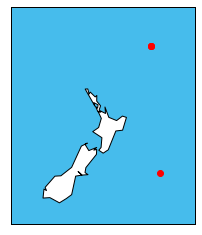

In [14]:
''' Plot the out of bounds stations '''

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

try:
    print('Stations excluded from the valid active station inventory')
    print(f'{invalid_st_list}')
    # determine range to print based on min, max lat and lon of the data
    st_lat = [x[1] for x in invalid_st_list]
    st_lon = [x[2] for x in invalid_st_list]

    lat_min = min(st_lat) - 5
    lat_max = max(st_lat) + 5
    lon_min = min(st_lon) - 20
    lon_max = max(st_lon) + 5

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max-lon_min)/2,
                projection='merc',
                resolution = 'c',
                area_thresh=10000.,
                )

    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmapboundary(fill_color='#46bcec')
    m.fillcontinents(color = 'white',lake_color='#46bcec')
    # convert lat and lon to map projection coordinates
    lons, lats = m(st_lon, st_lat)
    # plot points as red dots
#    plt.figure(figsize=(5, 5))
    m.scatter(lons, lats, marker = 'o', color='r', zorder=5)
    plt.show()

except Exception as err:
    print("Error message:", err)
    if debug:
        import traceback
        print(traceback.format_exc())

## Plot stations by sensor type
we plot all the valid land stations and color code them by type. The legend gives a description of the types, their capabilities, and quantities. The sensor types are distinguished between strong motion, weak motion, short-period, broadband, velocity measure, and acceleration measure. "[Not all ground motion sensors are created equal.](https://earthquake.alaska.edu/not-all-ground-motion-sensors-are-created-equal)" because not all ground motions are the same.

___TODO___ add google earth enging: 
* https://github.com/shiweihappy/earthengine-py-notebooks
* https://medium.com/@giswqs/300-jupyter-python-notebooks-for-using-google-earth-engine-with-interactive-mapping-bc3443119377 

### Observations about the sensor placement
Geonet has 5 types of sensors placed in various toplogical configurations. The plot shows that
* The shield network is, primarly, dominated by 59% strong mostion high broadband sensors measuring acceleration at high sampling rate 100-200Hz and, secondly, by 36% weak motion sensors measuring velocity at an extremely short-period sampling rate ~100Hz.
* A large propotion of weak motion sensors and the four broadband sensors, measuring acceleration at a very low sampling rate (1Hz), are placed in the northern island.
* The weak motion sensors, measuring velocity at a low sampling rate (1Hz). are uniformly scattered across both the northern and southern islands, except for the conscentration of sensors around the location -39.5, 175.5.
* Also the weak motion sensors measuring velocity high broadband sampled at 100-200Hz, are uniformaly scatter but concentrated in mostly to the north of latitude -44.0. There are two denser concentration of sensors around locations -38.5, 175.5 and -39.6, 176.5

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


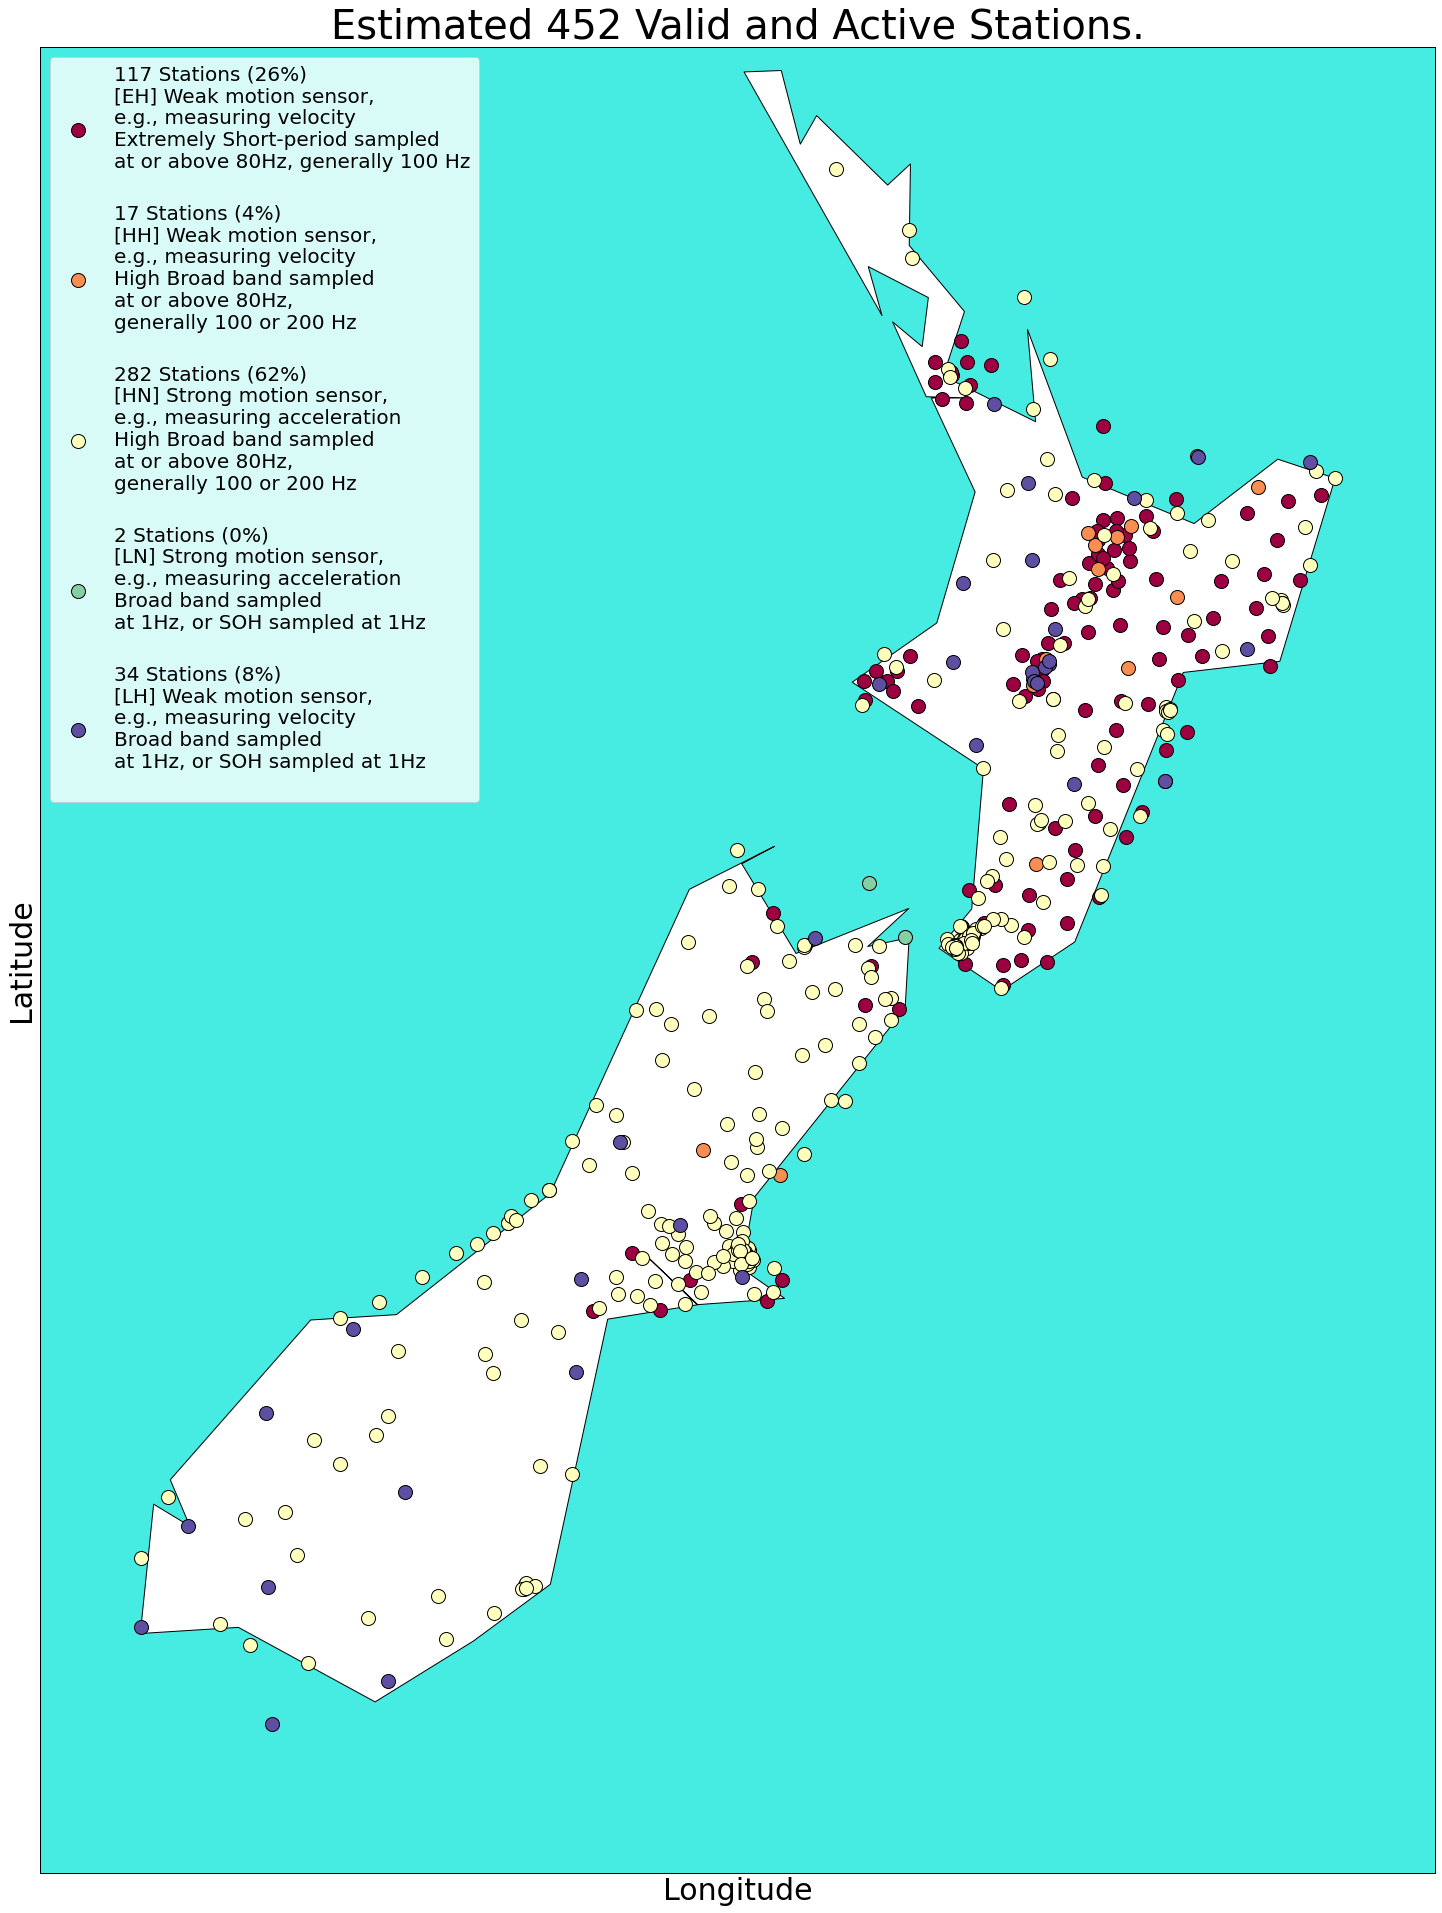

In [15]:
'''
Station Topgraphy by Station Type
'''
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap

lstStationType = []
lstStationLoc = []

try:
    ''' prepare the list data of station types and coorinate '''
    for _,st_type,st_lat,st_lon in st_list:
        lstStationType.append(st_type)
        lstStationLoc.append([st_lat,st_lon])
    arrStationLoc = np.array(lstStationLoc)
    st_type_dict = cls_st.get_types()

    core_samples_mask = np.zeros_like(lstStationType, dtype=bool)
    core_samples_mask[0:sum([len(x) for x in lstStationType])] = True

    ''' assign the color codes to the unique station types '''
    unique_st_types = set(lstStationType)
    colors = [plt.cm.Spectral(each) 
              for each in np.linspace(0, 1, len(unique_st_types))]

    st_lat = [x[0] for x in lstStationLoc]
    st_lon = [x[1] for x in lstStationLoc]

    lat_min = min(st_lat) - 1
    lat_max = max(st_lat) + 1
    lon_min = min(st_lon) - 1
    lon_max = max(st_lon) + 1

    # create map using BASEMAP
    plt.figure(figsize=(25, 40))
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max-lon_min)/2,
                projection='merc',
                resolution = 'c',
                area_thresh=10000.,
               )
    
    m.drawcoastlines()
    m.drawcountries()
    #m.drawstates()
    m.drawmapboundary(fill_color='#46ece1')
    m.fillcontinents(color = 'white',lake_color='#46bcec')

    ''' Begin plotting the color coded stations '''
    #plt.figure(figsize=(30, 40))
    for k, col in zip(unique_st_types, colors):
        class_member_mask = (np.array(lstStationType) == k)
        xy = arrStationLoc[class_member_mask & core_samples_mask]
        s_legend = str(len(xy))+' Stations ('+str(round(100*len(xy)/len(st_list)))+'%) \n['+k+'] '+str(st_type_dict[k]+'\n')
        x,y = m(xy[:, 1], xy[:, 0])
        m.plot(x, y, 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14, label=s_legend)
    #    m.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
    #             markeredgecolor='k', markersize=14, label=s_legend)
    
    plt.title('Estimated %d Valid and Active Stations.' % len(arrStationLoc), fontsize=40)
    plt.xlabel('Longitude', fontsize=30)
    plt.ylabel('Latitude', fontsize=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.legend(loc='upper left', fontsize=20)
    plt.show()

except Exception as err:
    print("Error message:", err)
    if debug:
        import traceback
        print(traceback.format_exc())

## CLUSTERING STATIONS
One of the spatial clustering categories from GIS theory and technology tools, for objects with spatial geographical coordinates, a [cluster is an object of the spatial proximity base](https://ieeexplore.ieee.org/document/7529539) rather than as a clustering property similarity. The objective is to find clusters of stations that are with a given proximity to each other. The intent is to decide whether these stations, if they were able to communicate with each other, would conform to the properties of EEW rings. 

There are [several clustering methods](https://medium.com/locale-ai/geospatial-clustering-types-and-use-cases-6caedecfc7f0) that can be employed for grouping data with similar features. For the purpose of our exercise of clustering spatial data, partition clustering: [k-means](https://www.analyticsvidhya.com/blog/2021/02/simple-explanation-to-understand-k-means-clustering/), [k-medoids](https://www.geeksforgeeks.org/ml-k-medoids-clustering-with-example/), or [CLARA](https://medium.com/analytics-vidhya/partitional-clustering-using-clarans-method-with-python-example-545dd84e58b4) (Classification Large Application) [are unsuitable](https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/). Moreover, we would prefer a clustering algorithm that produce as many clusters based on the proximity criteria rather than grouping points that generate a desired "k" count of clusters. 

We are not interested in hierarchical clustering, such as [Agglomerative](https://medium.com/@MaheshGadakari/hierarchical-agglomerative-clustering-hac-with-single-linkage-method-1159fa623d52) or [Divisive](https://arxiv.org/pdf/1506.08977.pdf) hierarchical clustering that are also designed to generate a specified number of clusters. [DENCLUE](https://link.springer.com/chapter/10.1007/978-3-540-74825-0_7) is good for large dimensional data sets. It employs a hill climbing technique to estaimte the local optima. Since we are working only with geospatial data with latitude and longitude coordinates, we don't need to use denclue. If anyone wishes to implement, there's a [buggy version of denclue2](https://github.com/mgarrett57/DENCLUE) that can be repurposed.

There are also issues with clustering geospatial data. [Around the equator the results should be fairly accurate.](https://stackoverflow.com/questions/24762435/clustering-geo-location-coordinates-lat-long-pairs-using-kmeans-algorithm-with) but close to one of the poles the results won't be useful at all. It might, however, work as a pre-pocessing step or for applications with low precision requirements, e.g. small, non-overlapping and very distinct clusters.

In [3]:
''' Construct DataFrame of the Station Data

    Only apply to strong and weak motion stations with sampling rates > 80Hz
    Convert the data as an Numpy array before clustering
    
    __lst_st_type_80Hz_above: list of stations types with sampling rate > 80Hz
    station_df: dataframe that holds the station name,type', and lat/lon pairs
'''

import pandas as pd

''' Define the list of station types to filter the station inventory data {"EH","HH","HN","LN"}'''
__lst_st_type_80Hz_above = ["HN","LN"]
lst_st_80Hz_above = [[st_name,st_type, st_lat,st_lon]
                          for st_name,st_type,st_lat,st_lon in st_list 
                          if st_type in __lst_st_type_80Hz_above]
station_df = pd.DataFrame(lst_st_80Hz_above, columns=['st_name','st_type','st_lat','st_lon'])

''' Initialize label column as -1 indicating individual stations to be noise to begin with '''
l_label = [-1]*station_df.shape[0]
station_df['label'] = -1
station_df.set_index(['st_type','label'])

print('%d stations of type %s are ready for clustering' % (station_df.shape[0],__lst_st_type_80Hz_above))

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


284 stations of type ['HN', 'LN'] are ready for clustering


### Assessing the Clusterability
___skip this cell to avoid a long process___

In [7]:
''' Clustering Tendency

    Examines the Improved Visual Assessment of Tendency (iVAT) and Hopkins Test
    A Monte Carlo Simulation is run on the iVAT and Hopkins Test to arrive at scores that are withing
    a 95% confidence interval. 
'''
from pyclustertend import ivat, hopkins, assess_tendency_by_mean_metric_score
import numpy as np
import scipy.stats as st
import math

station_coordinates = station_df[['st_lat','st_lon']].to_numpy()

print('This will take a while for the clusterability tests of %d stations' % station_coordinates.shape[0])

''' set sampling size to 5% of the dataset to compute hopkins test score
'''
n_sampling_size = int(station_coordinates.shape[0]*0.05)     # set the sample size to 5% of the stations
#sum_hopkins_scores = 0

''' iterate the test > 250 times to calculate the average score
    because it depends on the random sample selected to calculate
'''
n_iter = 320    # number of iterations to run each of the functions
arr_score = np.empty(n_iter, dtype=float)

for i in range(0,n_iter):
    arr_score[i] = hopkins(station_coordinates,n_sampling_size)

print("Hopkins Test Score %0.3f averaged over %d iterations " % (1-np.mean(arr_score),n_iter))
print("Estimated iterations %d for 95 percent confidence level" % math.ceil((1.96*np.std(arr_score)/0.01)**2))
s_conf_int = str(st.t.interval(1-0.05, arr_score.shape[0]-1, np.mean(arr_score), st.sem(arr_score)))
print("Returns a %s confidence interval\n" % s_conf_int)

''' Estimate the number of clusters for the assessment tendency mean metric score 
    to be number of stations / minPoints in a cluster; 
    minPoints = 3 becasue the P-wave detector requires readings from 3-4 station
    iterate the test 50 times to calculate the average score
'''
n_iter = 50    # number of iterations to run each of the functions
n_clusters = int(station_coordinates.shape[0]/4)
sum_assess_tend_mean_scores = 0
arr_score = np.empty(n_iter, dtype=float)

for i in range(0,n_iter):
    arr_score[i] = assess_tendency_by_mean_metric_score(station_coordinates,n_clusters)

print("Assessment Tendency Mean Score %0.3f averaged over %d interations" % (np.mean(arr_score),n_iter))
print("Estimated iterations %d for 95 percent confidence level" % math.ceil((1.96*np.std(arr_score)/1)**2))
s_conf_int = str(st.t.interval(1-0.05, arr_score.shape[0]-1, np.mean(arr_score), st.sem(arr_score)))
print("Returns a %s confidence interval\n" % s_conf_int)
#print(str((1.96*np.std(arr_score)/0.1)**2))
#print(str((1.96*np.std(arr_score)/0.1)**2))
print(st.t.interval(1-0.05, arr_score.shape[0]-1, np.mean(arr_score), st.sem(arr_score)))
#print("Assessment Tendency Mean Score %0.3f" % (sum_assess_tend_mean_scores/10))

''' Use the iVAT plot to visualize the volume of dark and light squares.
    A high volume of dark squares indicate the data is clusterable. 
'''
ivat(station_coordinates, figure_size=[5,5])

print('Clusterability tests complete')


This will take a while for the clusterability tests of 279 stations
Hopkins Test Score 0.930 averaged over 320 iterations 
Estimated iterations 65 for 95 percent confidence level
Returns a (0.065741821685421711, 0.074789271613239769) confidence interval

Assessment Tendency Mean Score 45.827 averaged over 50 interations
Estimated iterations 13 for 95 percent confidence level
Returns a (45.298962736090083, 46.354370597243282) confidence interval

(45.298962736090083, 46.354370597243282)
Clusterability tests complete


### Get clustering sequence parameters

## CLOUD CLUSTERING
### Spatial Clustering Methods

#### DBSCAN
_Density-Based Spatial Clustering of Applications with Noise_ ([DBSCAN](https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/)) is the most appropriate clustering method because, as in this case, it is mostly used for ___clustering in planar space___ and is good for handling outliers. Unlike k-means clustering that considers the variance, DBSCAN considers a distance function. The objective is to cluster stations with a maximum distance between each other. Inherent ___problem of DBSCAN___ is that it characterises data points to be in the same clusted if pair-wise data points satisfy the epsilon condition. This would not adequately satisfy the required condition that all data points in a a cluster are within the desired epsilon distance. It uses the concept of density reachability and density connectivity.

#### HDBSCAN

_Density-Based Clustering Based on Hierarchical Density Estimates_ ([HDBSCAN](https://link.springer.com/chapter/10.1007%2F978-3-642-37456-2_14)) was developed by Campello, Moulavi, and Sander (2013) - a simplified tree of significant clusters are constructed for obtaining a “flat” partition consisting of only the most significant clusters (possibly corresponding to different density thresholds). [How HDBSCAN works](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) is "it extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters."

#### OPTICS

_Ordering points to identify the clustering structure_ [OPTICS](https://towardsdatascience.com/clustering-using-optics-cac1d10ed7a7) addresses the [limitations of input parameter selection for DBSCAN](https://www.mdpi.com/2079-9292/8/10/1094). However, OPTICS requires distance computations for all pairs of objects to create a reachability plot. Another interesting aspect of the OPTICS algorithm is an extension of it used for outlier detection, called OPTICS-OF (OF for Outlier Factor). This will give an outlier score to each point, that is a comparison to its closest neighbors rather than the entire set. One downfall of OPTICS-OF detection is that is cannot handle duplicates well. If enough points occupy the same space, they can have a reach-ability distance of 0, which causes problems in our local outlier factor calculations.

## Graph Clustering
### Create simple graph of the station topology
The subgraphs are created from edge weight constraints. Thus, the edge weight representing the distance between adjacent nodes are constrained by a minimum distance. 

The ___Naive Greedy modularity communities___ is very slow and can take several minutes. All other graph communities clustering methods complete in a few seconds.

#### TODO

#### Grid-based clustering
[Grid-based clustering](https://www.researchgate.net/publication/50315642_A_Survey_of_Grid_Based_Clustering_Algorithms_) would also work. Of particular interest is the [STING](https://www.geeksforgeeks.org/difference-between-sting-and-optics/), [Wave cluster](), and [ASGC]() grid-based spatial clustering algorithms.

[Affinity Propagation](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html) is a graph based exemplar voting method where the user doesn’t need to specify the number of clusters. Since it partitions the data just like K-Means we expect to see the same sorts of problems, particularly with noisy data. [Mean Shift](https://www.geeksforgeeks.org/ml-mean-shift-clustering/) is another option if you don’t want to have to specify the number of clusters. It is centroid based, like K-Means and affinity propagation, but can return clusters instead of a partition. Spectral clustering can best be thought of as a graph clustering. For spatial data one can think of inducing a graph based on the distances between points (potentially a k-NN graph, or even a dense graph).

We may also consider State Vector Machine (SVM) to further separate the clusters and [reduce the noise](https://www.researchgate.net/publication/325116579_Scalable_density_based_spatial_clustering_with_integrated_one-class_SVM_for_noise_reduction).

For a list of valid metrics for the clustering names, run ```sklearn.neighbors.VALID_METRICS['kd_tree']``` in cell.

### Formulate a Clustering Strategy

In [4]:
import numpy as np

''' To run an individual clustering sequence for particular parameters
    set the following attributes

    OPTIONS for _s_cloud_clust_name:
    
    Cloud
    (01) 'DBSCAN'     density-based scaning spatial clustering bounded by epsilong density and minPts
    (02) 'HDBSCAN'    higherarchical DBSCAN
    (03) 'AFFINITYPROPAGATION'
    (04) 'OPTICS'
    (05) 'KMEANS'
    (06) 'SPECTRAL'  -- Spectral Clustering
    (07) 'DENCLUE'    density-based clustering using Kernel Density Estimation and Hill-climbing
    (08) 'BIRCH'
    (09) 'AGGLOMERATIVE'
    
    Graph
    (10) 'ASYNC-LPA' -- asyn_lpa_communities; specify the epsilon, weight, and seed parameters
    (11) 'LPC'       -- label_propagation_communities; combination of synchronous and aysnchronous 
    (12) 'GREEDY'    -- greedy_modularity_communities
    (13) 'NAIVE-GREEDY'  -- _naive_greedy_modularity_communities; very slow O(N^4)
    (14) 'LUKES'         -- lukes_partitioning; works only on trees
    (15) 'ASYNC-FLUID'   -- asyn_fluidc; Fluid Communities require connected Graphs
    (16) 'GIRVAN-NEWMAN' -- 

    The two classes of cluster tequniques are cloud and graph clustering
'''
''' @TODO resolve cloud vs grah in cluster_quality.py using a dictionary '''
_cluster_technique = "cloud"     # options are {"cloud","graph"} 
_s_cloud_clust_name = 'OPTICS'  # set the clustering algorithm

'''
    Set the maximum distance between points in a cluster to define the distance for epsilong and
    the density for the minimum number of points required in a cluster
'''
_l_max_distance = 10.0          # set distance for epsilon = distance * 6830.0088 
_n_min_cloud_clust_size = 2     # set the density

'''
    For KMEANS clustering method, be sure to enable max_iter & random_state parameters below
    if you don't wish to use them, disable the max_iter & random_state for other clustering methods

    ** Change the three parameters below to see how the clustering behaves
'''

''' DBSCAN, HDBSCAN, AFFINITYPROPAGATION, OPTICS, KMEANS,MEANSHIFT paramter dictionary

    @parameters
    1) DBSCAN 
    algorithm = {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’

    2) HDBSCAN 
    algorithm = {'best','generic','prims_kdtree','prims_balltree',
                    'boruvka_kdtree','boruvka_balltree'}     # default = 'best'
    cluster_method = {'eom', 'leaf'}     # use this parameter to set "cluster_selection_method"

    3) OPTICS 
    cluster_method = {'xi', 'dbscan'}    # use when running OPTICS
    algorithm = {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
    
    4) SPECTRAL
    algorithm = {"kmeans","discretize"}
    cluster_method = {"arpack", "lobpcg", "amg"}
    metric = {"precomputed","precomputed_nearest_neighbors","nearest_neighbors","rbf"}

    metric = {'haversine','euclidean','precomputed'}   # any of listed in scipy.spatial.distance
'''
dict_clust_params = {"distance_km":_l_max_distance,
                     "minimum_samples":_n_min_cloud_clust_size,
                     #"minimum_cluster_size":_n_min_cloud_clust_size,
                     "algorithm": 'auto',
                     "metric": 'haversine',
                     "cluster_method": 'dbscan',
                     #"max_iter": 300,
                     #"random_state": 5,
                     #"n_clusters": 3,
                     #"weight": 'distance',
                     #"seed": np.random,     # values: int, np.random, None
                     #"maximum_node_weight": 20,
                     "fit_predict": False
                    }

print('Prepared %s clustering parameters for a %s clustering sequence\n%s'
      % (_cluster_technique,_s_cloud_clust_name, dict_clust_params))


Prepared cloud clustering parameters for a OPTICS clustering sequence
{'distance_km': 10.0, 'minimum_samples': 2, 'algorithm': 'auto', 'metric': 'haversine', 'cluster_method': 'dbscan', 'fit_predict': False}


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Execute the Clustering Strategy

In [5]:
''' Combined cloud and graph clustering '''
import sys; sys.path.insert(1, '../lib')
import cluster_quality as cq

if debug:
    import importlib
    cq = importlib.reload(cq)
#d import importlib
#d cq = importlib.reload(cq)
try:
    clust_quality = cq.cluster_quality_metric()
    __st_clust_df = pd.DataFrame([])
    __st_clust_df = clust_quality.get_clusters(
        dict_clust_params,
        station_df.copy(),
        _cluster_technique,
        _s_cloud_clust_name)
    ''' Number of clusters in labels, ignoring noise if present. '''
    _n_no_noise_clust = len([x for x in __st_clust_df['label'].unique() if x > -1])
    print('Parameters:', dict_clust_params)
    print('%s clustering process completed with %d clusters!' % (_s_cloud_clust_name, _n_no_noise_clust))

except Exception as err:
    print("Error message:", err)
    if debug:
        import traceback
        print(traceback.format_exc())

Parameters: {'distance_km': 10.0, 'minimum_samples': 2, 'algorithm': 'auto', 'metric': 'haversine', 'cluster_method': 'dbscan', 'fit_predict': False}
OPTICS clustering process completed with 18 clusters!


In [6]:
if debug:
    import importlib
    cq = importlib.reload(cq)

''' @_force_regularity = {'Absolute','Average','None'}
       Absolute - is a brute force to check all constraints
       Average - checks if average degree of nodes in cluster >= minPts-1
       minPoints - simply checks for minimum samples and doesn't enforce regularity
       None - doesn't do anything but simply creates a list of simple graphs corresponding to each cluster
'''
_force_regularity = 'None'
print('Regularity enforcement: %s' % (_force_regularity))

''' apply r-regularity to further validate the culsters '''
if _force_regularity in ['Absolute','Average','minPoints','None']:
    _dict_reg_param = {"force_regularity":_force_regularity}
    __st_clust_df,lst_G_simple = clust_quality.get_r_regular_clusters(_dict_reg_param,__st_clust_df)

Regularity enforcement: None


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Clustering Quality Metric
[Evaluating Clustering Results](https://towardsdatascience.com/evaluating-clustering-results-f13552ee7603)

### Community Clustering Quality

Conductance requires that singelton clusters be eliminated otherwise it gives a zerodivision error. Therefore, the a set of valid clusters must be reconstructed; where in addition to singelton clusters all clusters below the minPts were also eliminated. However, modularity, coverage, and performance quality measures require the original community cluster list and the and the corresponding graph with all the nodes in the cluster. An alternative is to delete all nodes in the simple graph that do not belong to clusters < minPts to create a new graph and then calculate the modularity, coverage, and performance with the list of valid clusters. However, that would not reveal the true cluster quality of each method but would provide a procedure for determining the valid set of clusters along with the new reduced graph.

In [7]:
''' Get cluster quality metrics '''

import sys; sys.path.insert(1, '../lib')
import cluster_quality as cq
import numpy as np

if debug:
    import importlib
    cq = importlib.reload(cq)

try:
    if len(__st_clust_df['label'].unique()) <= 1:
        _s_err = 'Only 1 or less clusters were formed. Cannot proceed further with quality metrics'
        _s_err += "\nConsider rerunning the cluster sequence by changing the method, maxDistance, and minPts"
#d        raise ValueError('Only 1 or less clusters were formed. Cannot proceed further with quality metrics')
        raise ValueError(_s_err)

    clust_quality = cq.cluster_quality_metric()
    print('Parameters:', dict_clust_params)
    clust_quality.set_quality_frame(clustering_name=_s_cloud_clust_name, **dict_clust_params)
    __clust_quality_df_ = clust_quality.get_quality_metrics(__st_clust_df)
    print('Cluster quality measure computation complete!')
    #print(__clust_quality_df_)
except Exception as err:
    print("Error message:", err)
    if debug:
        import traceback
        print(traceback.format_exc())

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Parameters: {'distance_km': 10.0, 'minimum_samples': 2, 'algorithm': 'auto', 'metric': 'haversine', 'cluster_method': 'dbscan', 'fit_predict': False}
Cluster quality measure computation complete!


## Display Cluster Quality

In [8]:
''' Display cluster quality measures '''

try:
    if __clust_quality_df_['Generated Cluster Count'].unique()[0] <= 1:
        raise ValueError('Clusters size is %d. Cannot estimate cluster quality indicators'
                         % __clust_quality_df_['Generated Cluster Count'])
    else:
        ''' For this unsupervised clustering method we do not have ground truth to computer most of the
            cluster quality indicators such as homogenity, competeness, v-measure, ARI, AMI. We can only
            computer the silhouett coefficient, calinski harabaz score, 
        '''
#d        print('')
#d        print('Clustering name: %s with Algorithm: %s, Method: %s, \nminPts >= %d, and density distance <= %d Km generated ...'
        _s_prnt = 'Clustering name: %s with Algorithm: %s, Method: %s,'
        _s_prnt += '\nCluster density minPts >= %d, and distance <= %d Km generated ...'
        print(_s_prnt
              % (str(__clust_quality_df_['Name'][0]),
                str(__clust_quality_df_['Algorithm'][0]),
                str(__clust_quality_df_['Method'][0]),
                __clust_quality_df_['Minimum Points'],
                __clust_quality_df_['Maximum Distance']))
        print('Starting with %d %s type stations out of %d clusters %d clusters have minPts >= %d per cluster.'
              % (__clust_quality_df_['Station Quantity'],
                 __clust_quality_df_['Station Types'][0],
                 __clust_quality_df_['Generated Cluster Count'],
                 __clust_quality_df_['Valid Cluster Count'],
                 __clust_quality_df_['Minimum Points']))
        ''' Valid cluster are thos with number of stations in cluster >= minPts '''
        print('Number of total nodes in valid clusters: %d and noise %d'
              % (__clust_quality_df_['Clustered Station Count'],
                 __clust_quality_df_['Unclsutered Noise Count']))
        print('\nIn the valid clusters with minPts >= %d and density distance <= %d' 
              % (__clust_quality_df_['Minimum Points'],
                __clust_quality_df_['Maximum Distance']))
        print('Average degree of nodes:\t\t%0.4f'
              % (__clust_quality_df_['Average Node Degree']))
        print("Modularity score [-1.0,1.0]:\t\t%0.4f"
              % __clust_quality_df_['Modularity'])
        print("Conductance average [-1.0,1.0]:\t\t%0.4f"
              % (__clust_quality_df_['Conductance Average']))
        print("Coverage score [-1.0,1.0]:\t\t%0.4f"
              % __clust_quality_df_['Coverage Score'])
        print("Performance score [-1.0,1.0]:\t\t%0.4f"
              % __clust_quality_df_['Performance Score'])
        print("Silhouette Coefficient [-1.0,1.0]:\t%0.4f"
              % __clust_quality_df_['Silhouette Coefficient'])
        print("Calinski Harabaz score [0, inf]:\t%0.4f"
              % __clust_quality_df_['Calinski Harabaz score'])
        print("Davies Bouldin score [0, inf]:\t\t%0.4f"
              % __clust_quality_df_['Davies Bouldin score'])
        print("Dunn Index [0, inf]:\t\t\t%0.4f" 
              % __clust_quality_df_['Dunn Index'])

        ''' Extrinsic measures that cannot be used. They can be used if labels_true prevails
        
        print("Homogeneity: %0.4f" % metrics.homogeneity_score(labels_true, labels))
        print("Completeness: %0.4f" % metrics.completeness_score(labels_true, labels))
        print("V-measure: %0.4f" % metrics.v_measure_score(labels_true, labels))
        print("Adjusted Rand Index: %0.4f"
              % metrics.adjusted_rand_score(labels_true, labels))
        print(f"Adjusted Mutual Information: %0.4f" 
              % metrics.adjusted_mutual_info_score(labels_true, labels))
        print(f"F1 score: %0.4f"
              % f1_score(labels_true, labels, average='micro'))
        '''
except Exception as err:
    print("Error message:", err)
    if debug:
        import traceback
        print(traceback.format_exc())

Clustering name: OPTICS with Algorithm: auto, Method: dbscan,
Cluster density minPts >= 2, and distance <= 10 Km generated ...
Starting with 284 ['HN' 'LN'] type stations out of 18 clusters 18 clusters have minPts >= 2 per cluster.
Number of total nodes in valid clusters: 131 and noise 153

In the valid clusters with minPts >= 2 and density distance <= 10
Average degree of nodes:		11.8473
Modularity score [-1.0,1.0]:		0.5463
Conductance average [-1.0,1.0]:		0.0000
Coverage score [-1.0,1.0]:		1.0000
Performance score [-1.0,1.0]:		0.9726
Silhouette Coefficient [-1.0,1.0]:	-0.1130
Calinski Harabaz score [0, inf]:	6.0872
Davies Bouldin score [0, inf]:		2.2144
Dunn Index [0, inf]:			0.0073


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Parametric analysis of the clusters

A large propotion of the sensors could be clustered to have, at least, 03 senors in a cluster and that they are < 30Km distance from each other; which also is the basis for the ```eps = 30.0/6371.0088``` (epsilon convereted to radians using the length of Earth's radius 6371Km). The estimated number of _noise points_ tell us the number of sensors that didn't belong to any cluster. The particular geodedic data cannot be clustered with KD-Trees or any Tree algorithm. However, chosing ```algorithm = "ball_tree"``` is recommended as it is well suited for geospatial data clustering. The ```metric = "haversine"``` is naturally required to calculate the distance between two geographical points. Finally, the ```st_dbscan_arr``` comprising latitude and longitude decimal data is converted to radians to be consistent with using the _haversine_ distance funcation.

#### Plot results
1. [Plot DBSCAN results](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py) clusters with varied colors unique to each cluster
1. plot fault lines to show closes sensor in cluster to the fault line

Calculate and plot [cluster center most point](https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/).

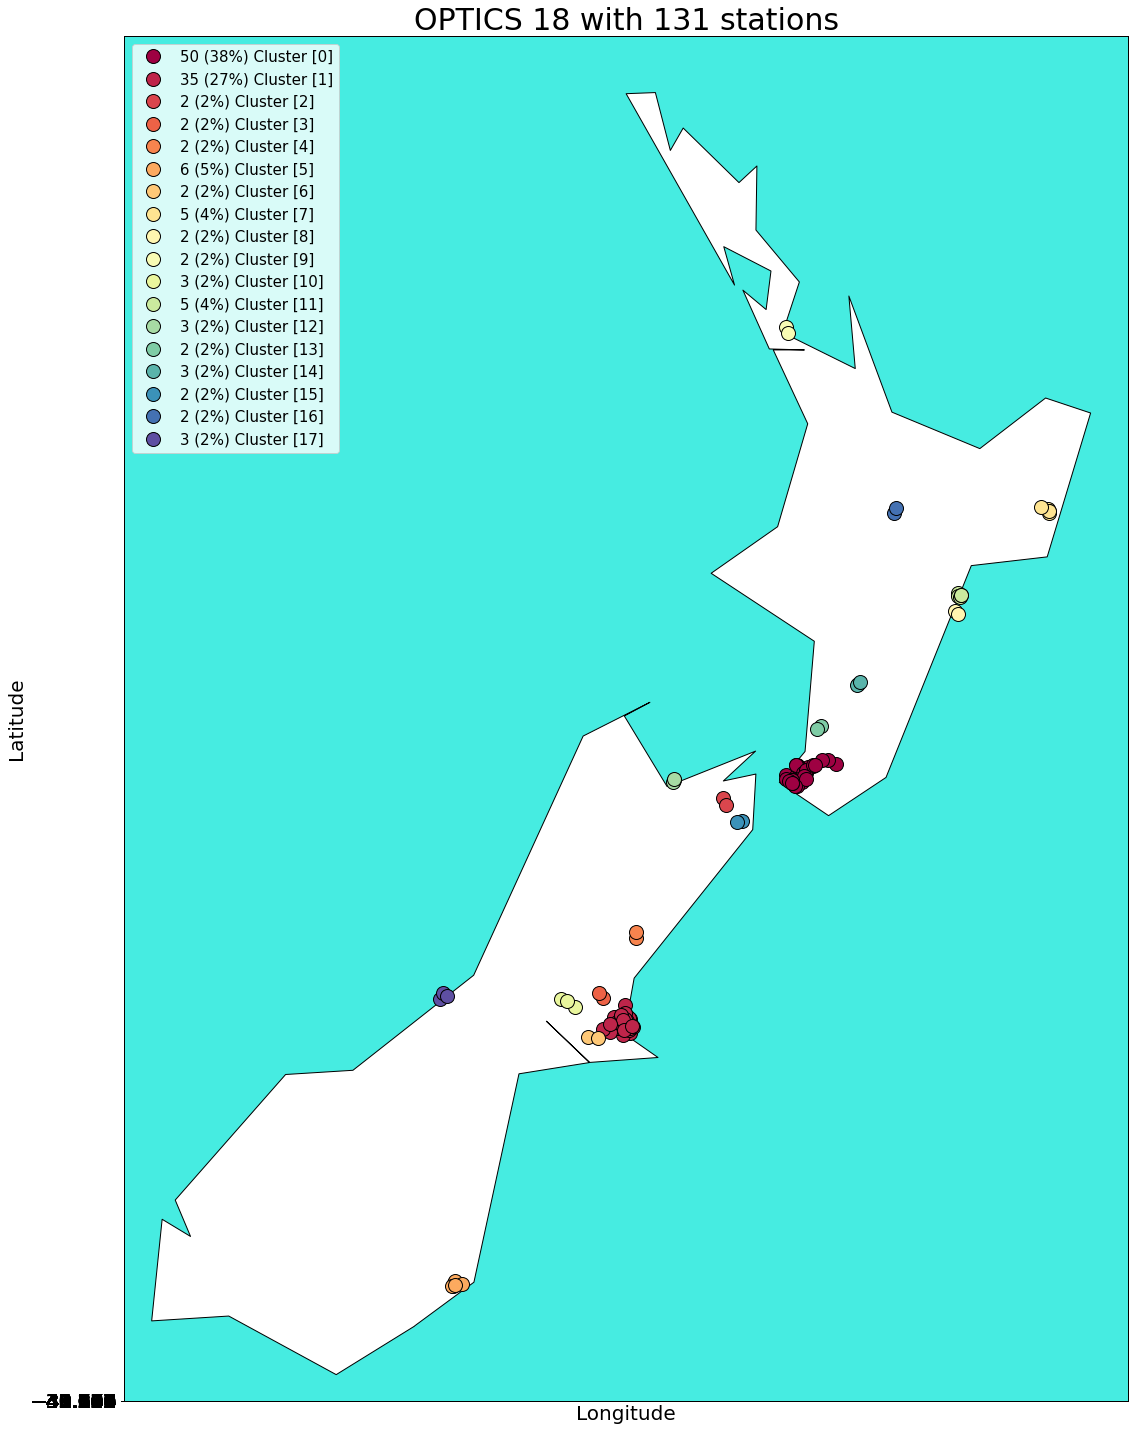

In [10]:
''' Plot clusters on a basemap '''
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

no_noise_df = __st_clust_df[__st_clust_df['label']!= -1]

''' Use list slice to plot all or a specific set of subgraphs 
    e.g., if you have 18 subgraphs [0,17]; to plot
            all: s = slice (0,18); 
    2nd to 6th: s = slice(1,6) 
'''
s=slice(0,len(no_noise_df['label'].unique()))
#s=slice(5,10,1)

try:
    ''' check if cluster size is same as all points '''
#d    if __clust_quality_df_[_clust_type_var][0] == 1:
#d        raise ValueError('There is only one cluster; does not make sense to plot')

    ''' remove all records with label = -1 indicated as noise (or clusters with singeltons)'''
    ''' further remove clusters that are < minPts
        because __st_clust_df contains all method clustered labels  '''
    _lst_uniq_label = list(sorted(no_noise_df['label'].unique()))[s]
    no_noise_df = no_noise_df.loc[no_noise_df["label"].isin(_lst_uniq_label)]
    if no_noise_df.shape[0] < 1 :
        raise ValueError('There no_noise clusters to plot')

    # create map using BASEMAP
    st_lat = no_noise_df['st_lat'].to_numpy()
    st_lon = no_noise_df['st_lon'].to_numpy()

    lat_min = min(st_lat) - 1
    lat_max = max(st_lat) + 3
    lon_min = min(st_lon) - 4
    lon_max = max(st_lon) + 1

    plt.figure(1,figsize=(18, 30))
#    ax  = fig.add_subplot(111)
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max-lon_min)/2,
                projection='merc',
                resolution = 'c',
                area_thresh=10000.,
               )

    m.drawcoastlines()
    m.drawcountries()
    #m.drawstates()
    m.drawmapboundary(fill_color='#46ece1')
    m.fillcontinents(color = 'white',lake_color='#46bcec')

    unique_labels = set(no_noise_df['label'])
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    #plt.figure(figsize=(15,20))
    for k, col in zip(unique_labels, colors):
        clust_df = no_noise_df.loc[lambda station_df: station_df['label'] == k]
        xy = clust_df[['st_lat','st_lon']].to_numpy()
        s_legend = str(len(xy))+' ('+str(round(100*len(xy)/no_noise_df.shape[0]))+'%) Cluster ['+str(int(k))+']'
        x,y = m(xy[:, 1], xy[:, 0])
        m.plot(x, y, 'o', markerfacecolor=tuple(col),
               markeredgecolor='k', markersize=14, label=s_legend)

    plt.title('%s %d with %d stations' 
              % (_s_cloud_clust_name, len(unique_labels), no_noise_df.shape[0]), fontsize=30)

    xtick = np.arange(min(st_lon),max(st_lon),1)
#    ax.xaxis.set_ticks(xtick)
#    ax.xaxis.set_ticks(x)
#    ax.xaxis.set_ticklabels(xtick)
    plt.yticks(st_lat,size=20)
    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)

    _s_plot_save_file = str("../images/outputs/map"+
                            "_clust-"+_s_cloud_clust_name+
                            "_forceReg-"+str(_force_regularity)+
                            "_minP-"+str(_n_min_cloud_clust_size)+
                            "_maxD-"+str(int(_l_max_distance))+
                            "_"+str(s)+
                            ".png").replace(" ","_")
    plt.savefig(_s_plot_save_file, bbox_inches='tight')
    plt.show()

except Exception as err:
    print("Error message:", err)
    if debug:
        import traceback
        print(traceback.format_exc())

#### Plot Noise
Plot of stations that do not belong to any cluster because they don't fit the epsilon criterion.

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


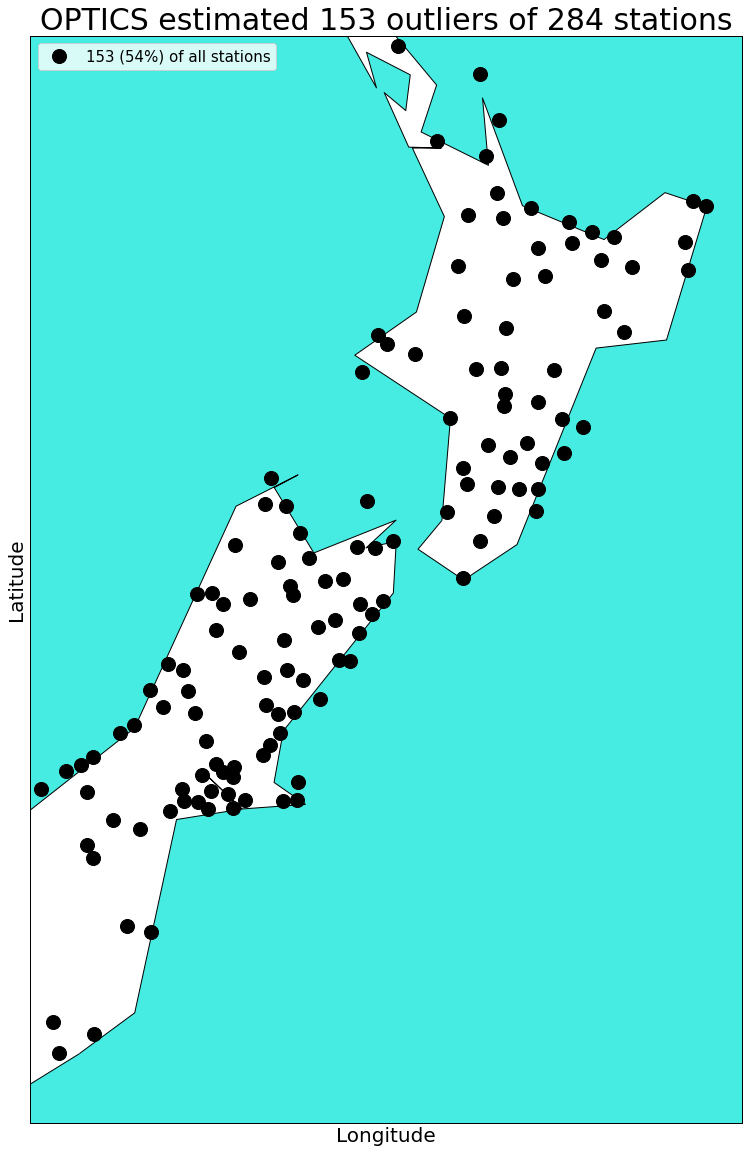

In [11]:
''' Plot noise cluster points on a map '''
#noise_st_arr = np.array([x for i,x in enumerate(tmp_arr) if np.any(tmp_arr[i][2] < 0)])

try:
#d    if n_noise_ <= 0:
#d    if not noise_st_arr.all():
#d        raise ValueError('%s did not produced noise clusters (or singeltons) to plot' % _s_cloud_clust_name)
#d    if cloud_clust_qual_df_['Unclsutered Noise Count'][0] <= 0:
#d        raise ValueError('%s did not produced noise clusters (or singeltons) to plot' % _s_cloud_clust_name)

    ''' retrieve records with label = -1 indicated as noise (or clusters with singeltons)'''
    noise_st_df = __st_clust_df.drop(no_noise_df.index)

    if noise_st_df.shape[0] <= 0:
        raise ValueError('%s did not produced noise clusters (or singeltons) to plot' % _s_cloud_clust_name)

    # create map using BASEMAP
    st_lat = no_noise_df['st_lat'].to_numpy()
    st_lon = no_noise_df['st_lon'].to_numpy()

    lat_min = min(st_lat) - 1
    lat_max = max(st_lat) + 1
    lon_min = min(st_lon) - 1
    lon_max = max(st_lon) + 1

    plt.figure(figsize=(15, 20))
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max-lon_min)/2,
                projection='merc',
                resolution = 'c',
                area_thresh=10000.,
               )
    
    m.drawcoastlines()
    m.drawcountries()
    #m.drawstates()
    m.drawmapboundary(fill_color='#46ece1')
    m.fillcontinents(color = 'white',lake_color='#46bcec')

    col = [0, 0, 0, 1]   # black
    s_legend = str(noise_st_df.shape[0])+' ('+str(round(100*noise_st_df.shape[0]/__st_clust_df.shape[0]))+'%) of all stations'
    x,y = m(noise_st_df['st_lon'].to_numpy(), noise_st_df['st_lat'].to_numpy())
    m.plot(x, y, 'o', markerfacecolor=tuple(col),
           markeredgecolor='k', markersize=14, label=s_legend)

    plt.title('%s estimated %d outliers of %d stations' 
              % (_s_cloud_clust_name, noise_st_df.shape[0], __st_clust_df.shape[0]), fontsize=30)
    plt.xticks(size=10)
    plt.yticks(size=10)
    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)

#d    _s_plot_save_file = str("../images/outputs/noise_clust_plot "+
#d                            _s_cloud_clust_name+"_"+str(_l_max_distance)+"_"+
#d                            str(_n_min_cloud_clust_size)+".png").replace(" ","_")
    _s_plot_save_file = str("../images/outputs/map"+
                            "_noise_clust-"+_s_cloud_clust_name+
                            "_forceReg-"+str(_force_regularity)+
                            "_minP-"+str(_n_min_cloud_clust_size)+
                            "_maxD-"+str(int(_l_max_distance))+
                            ".png").replace(" ","_")
    plt.savefig(_s_plot_save_file, bbox_inches='tight')
    plt.show()

except Exception as err:
    print("Error message:", err)
    if debug:
        import traceback
        print(traceback.format_exc())

### Density Reachability and Connectivity

We intend to calculate the [density reachability](https://www.geeksforgeeks.org/ml-dbscan-reachability-and-connectivity/). __Why?__ Let ε be the radius of a neighborhood with respect to some point. The _core objects_ the minimum number of objects in that ε-neighborhood. An object (or instance) _q_ is directly density reachable from object _p_ if _q_ is within the ε-Neighborhood of _p_ and _p_ is a core object. ___Density connectivity___ implies that Object _q_ is density-connected to object _p_ w.r.t ε and mimumum points if there is an object _o_ such that both _p_ and _q_ are density-reachable from object _o_ w.r.t _ε_ and the minimum points.

___Do now___
1. Build a complete graph from the cluster core objects
1. Use the nearest neigbour distance as the edge weigt
1. create a minimal spanning tree to connect all core objects

___future work___
1. also create a reachability metric from the clusters to the outliers
1. use that to determine a strategy for placing new nodes to improve the density connectivity and reachability


### Mean Nearest Neighbour Distance Statistics

Compute the mean distance between nearest neigbours of a minimum 3 points
* https://scikit-learn.org/stable/modules/neighbors.html
* https://pysal.org/notebooks/explore/pointpats/distance_statistics.html#Mean-Nearest-Neighbor-Distance-Statistics
* https://knaidoo29.github.io/mistreedoc/minimum_spanning_tree.html

### Histogram of Degrees (Connectedness)

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


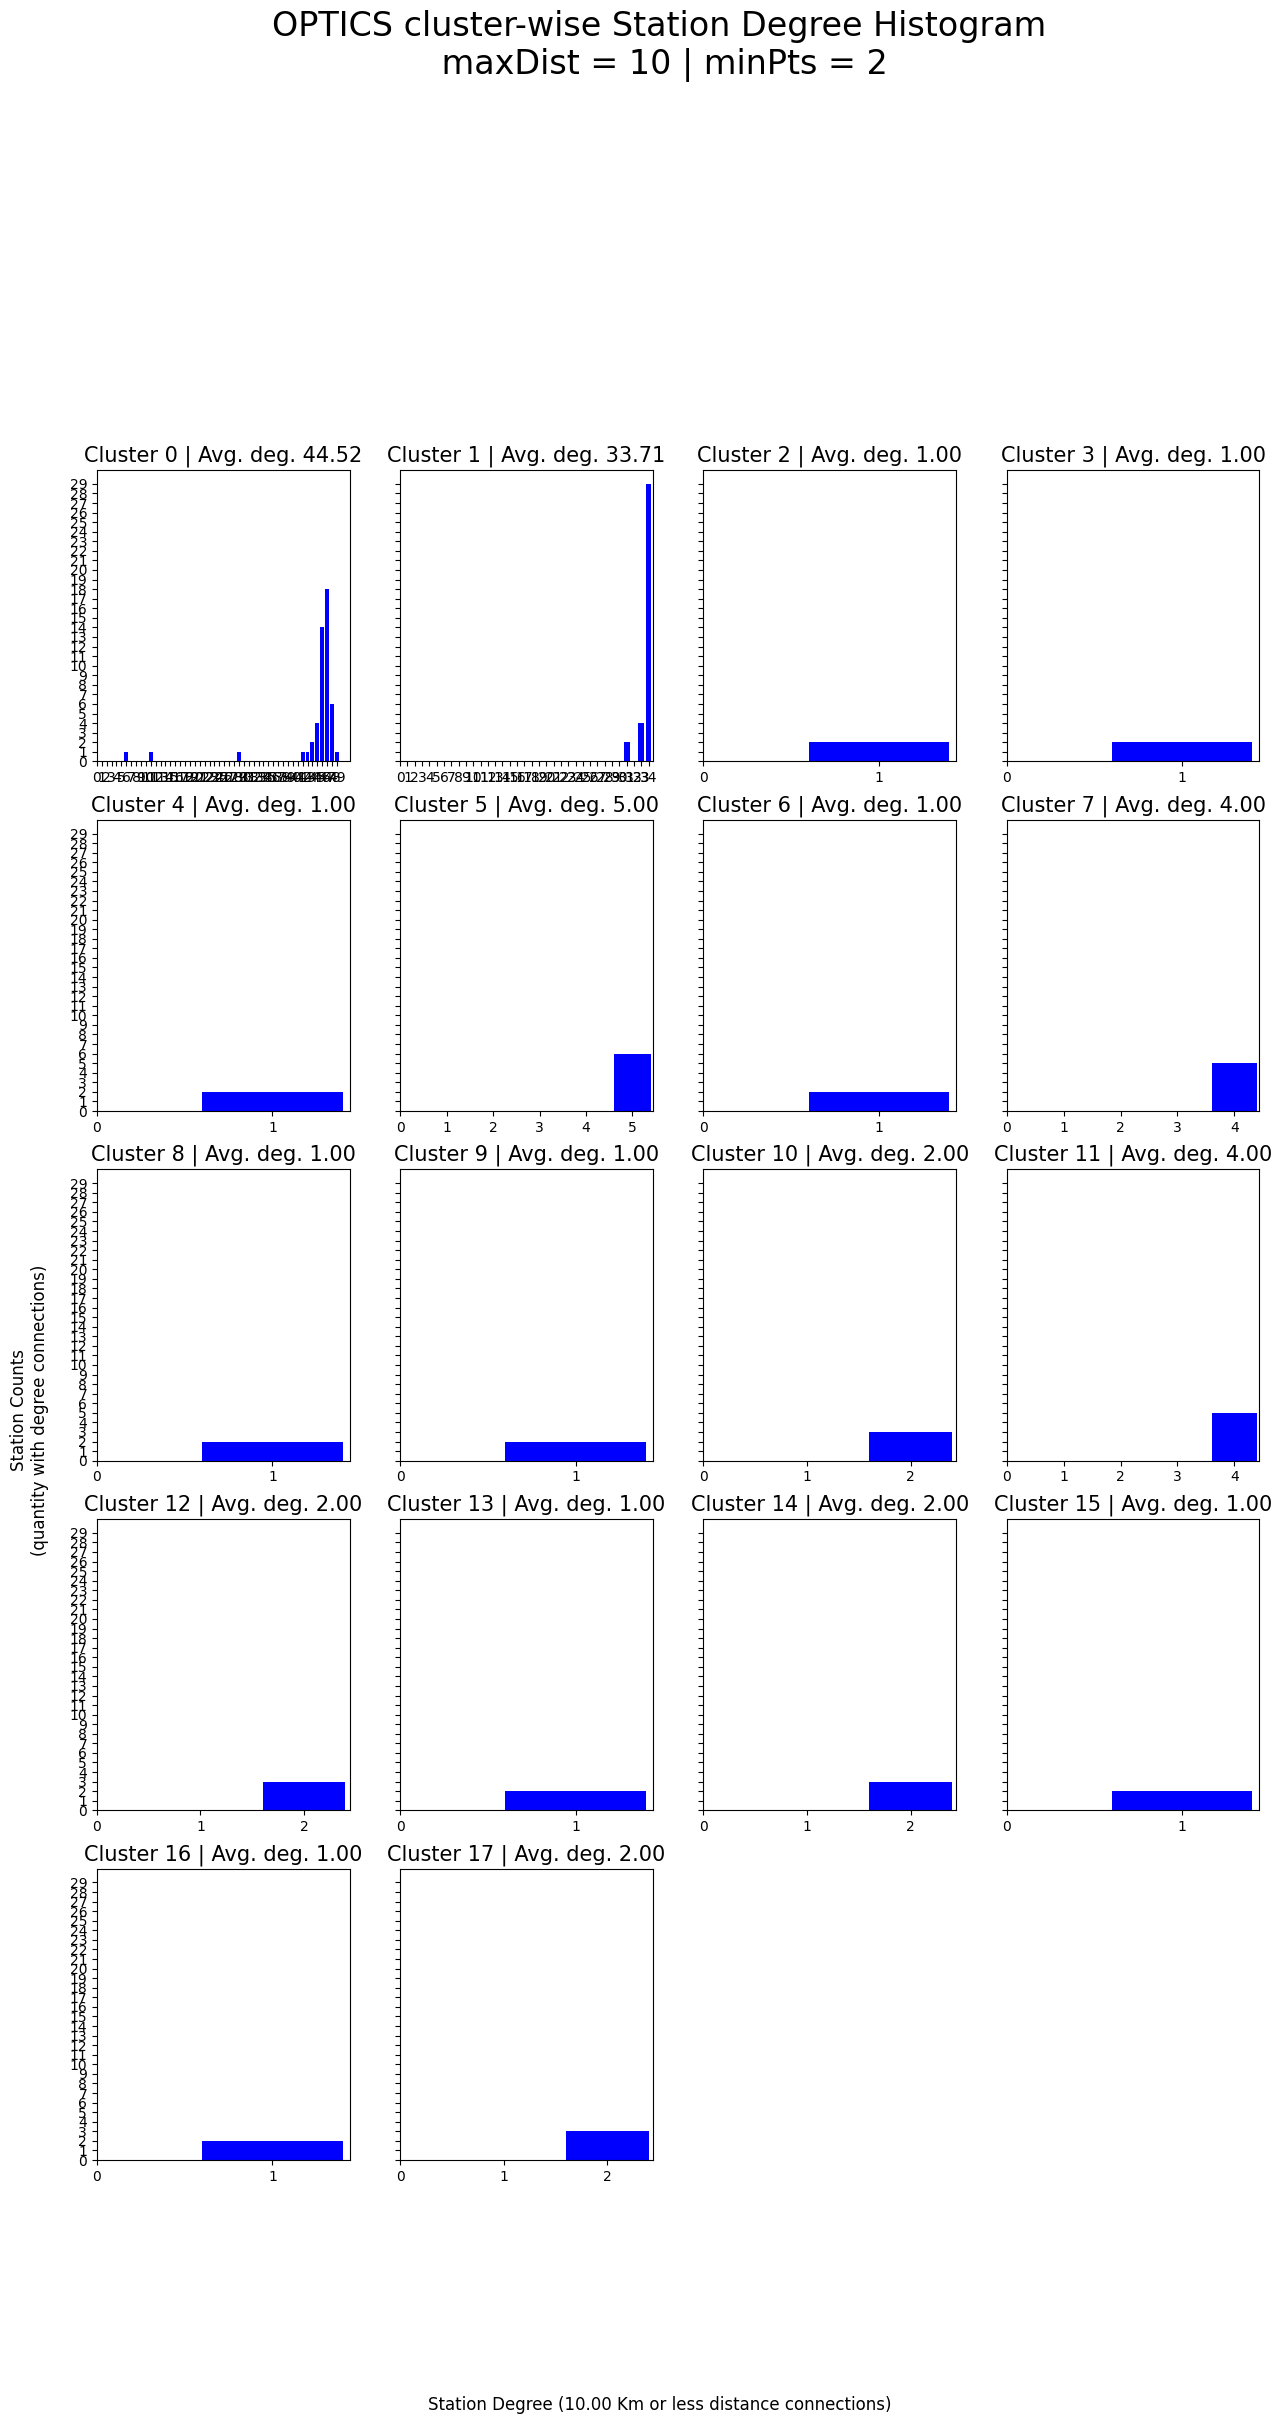

In [27]:
'''
    Plot degree histograms for each of the clusters indicating the number of nodes with a given degree
    
    TODO - fix problem when number of clusters is very high like in Agglomerative clustering to plot
    blocks of clusters at a time
'''
import collections
import math
import numpy as np
import matplotlib.pyplot as plt

try:
    if len(lst_G_simple) <= 0:
        raise AttributeError('Cannot plot histogram because the list is empty')

    __max_deg_cnt = -1     # to set the y-axis ticks
    '''
    if len(lst_G_simple) < 4:
        num_cols = len(lst_G_simple)%4
    else:
        num_cols = 4
    '''
    if len(lst_G_simple) < 3:
        num_cols = len(lst_G_simple)%3
    elif len(lst_G_simple) == 3:
        num_cols = 3
    elif len(lst_G_simple)%3 > len(lst_G_simple)%4:
            num_cols = 3
    else:
        num_cols = 4
     
    num_rows = math.ceil(len(lst_G_simple)/num_cols)

    fig, ax = plt.subplots(num_rows, num_cols, figsize=(15,num_rows*4), dpi=100, sharex=False, sharey=True)

    for clust_num, G in enumerate(lst_G_simple):
        degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
        _avg_degree = sum(degree_sequence)/len(degree_sequence)
        degreeCount = collections.Counter(degree_sequence)
        deg, cnt = zip(*degreeCount.items())
        row_num = math.floor(clust_num/num_cols)
        col_num = clust_num%num_cols

        if num_rows ==1:
            '''with one single subplot, ax already holds it without indexing'''
            if num_cols == 1:
                ax.bar(deg, cnt, width=0.80, color="b")
                ax.set_title('Cluster %d | Avg. deg. %0.2f' % (clust_num,_avg_degree),size=15)
                ax.set_xticks(np.arange(0, max(deg), 1))
            else:
                ax[col_num].bar(deg, cnt, width=0.80, color="b")
                ax[col_num].set_title('Cluster %d | Avg. deg. %0.2f' % (clust_num,_avg_degree),size=15)
                ax[row_num].set_xticks(np.arange(0, max(deg), 1))
        else:
            ax[row_num,col_num].bar(deg, cnt, width=0.80, color="b")
            ax[row_num,col_num].set_title('Cluster %d | Avg. deg. %0.2f' % (clust_num,_avg_degree),size=15)
            ax[row_num,col_num].set_xticks(np.arange(0, max(deg)+1, 1))
        if __max_deg_cnt < max(cnt):
            __max_deg_cnt = max(cnt)

    _s_title = ("%s cluster-wise Station Degree Histogram\n maxDist = %d | minPts = %d"
                % (_s_cloud_clust_name, _l_max_distance, _n_min_cloud_clust_size)) 
#    plt.suptitle(_s_cloud_clust_name + " cluster-wise Station Degree Histogram",size=24, y=1.2)
    plt.suptitle(_s_title,size=24, y=1.2)
    #st.set_y(0.95)
    fig.subplots_adjust(top=0.97)
    plt.yticks(np.arange(0, __max_deg_cnt+1, 1))
    x_share_axis_text = 'Station Degree (%0.2f Km or less distance connections)' % _l_max_distance 
    fig.text(0.5, 0.0,
             x_share_axis_text,
             ha='center',size=12)
    fig.text(0.08, 0.5,
             'Station Counts\n(quantity with degree connections)',
             ha='center', va='center', rotation='vertical', size=12)
    #fig.tight_layout()

    ''' remove empty plots '''
    for i in range(len(lst_G_simple),num_cols*num_rows):
#        fig.delaxes(ax[num_rows-1,i%4])
        fig.delaxes(ax[num_rows-1,i%num_cols])

    _s_plot_save_file = str("../images/outputs/histo"+
                            "_clust-"+_s_cloud_clust_name+
                            "_forceReg-"+str(_force_regularity)+
                            "_minP-"+str(_n_min_cloud_clust_size)+
                            "_maxD-"+str(int(_l_max_distance))+
                            ".png").replace(" ","_")
    plt.savefig(_s_plot_save_file, bbox_inches='tight')

    plt.show()

except Exception as err:
    print("Error message:", err)
    if debug:
        import traceback
        print(traceback.format_exc())

### Plot all Subgraphs

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


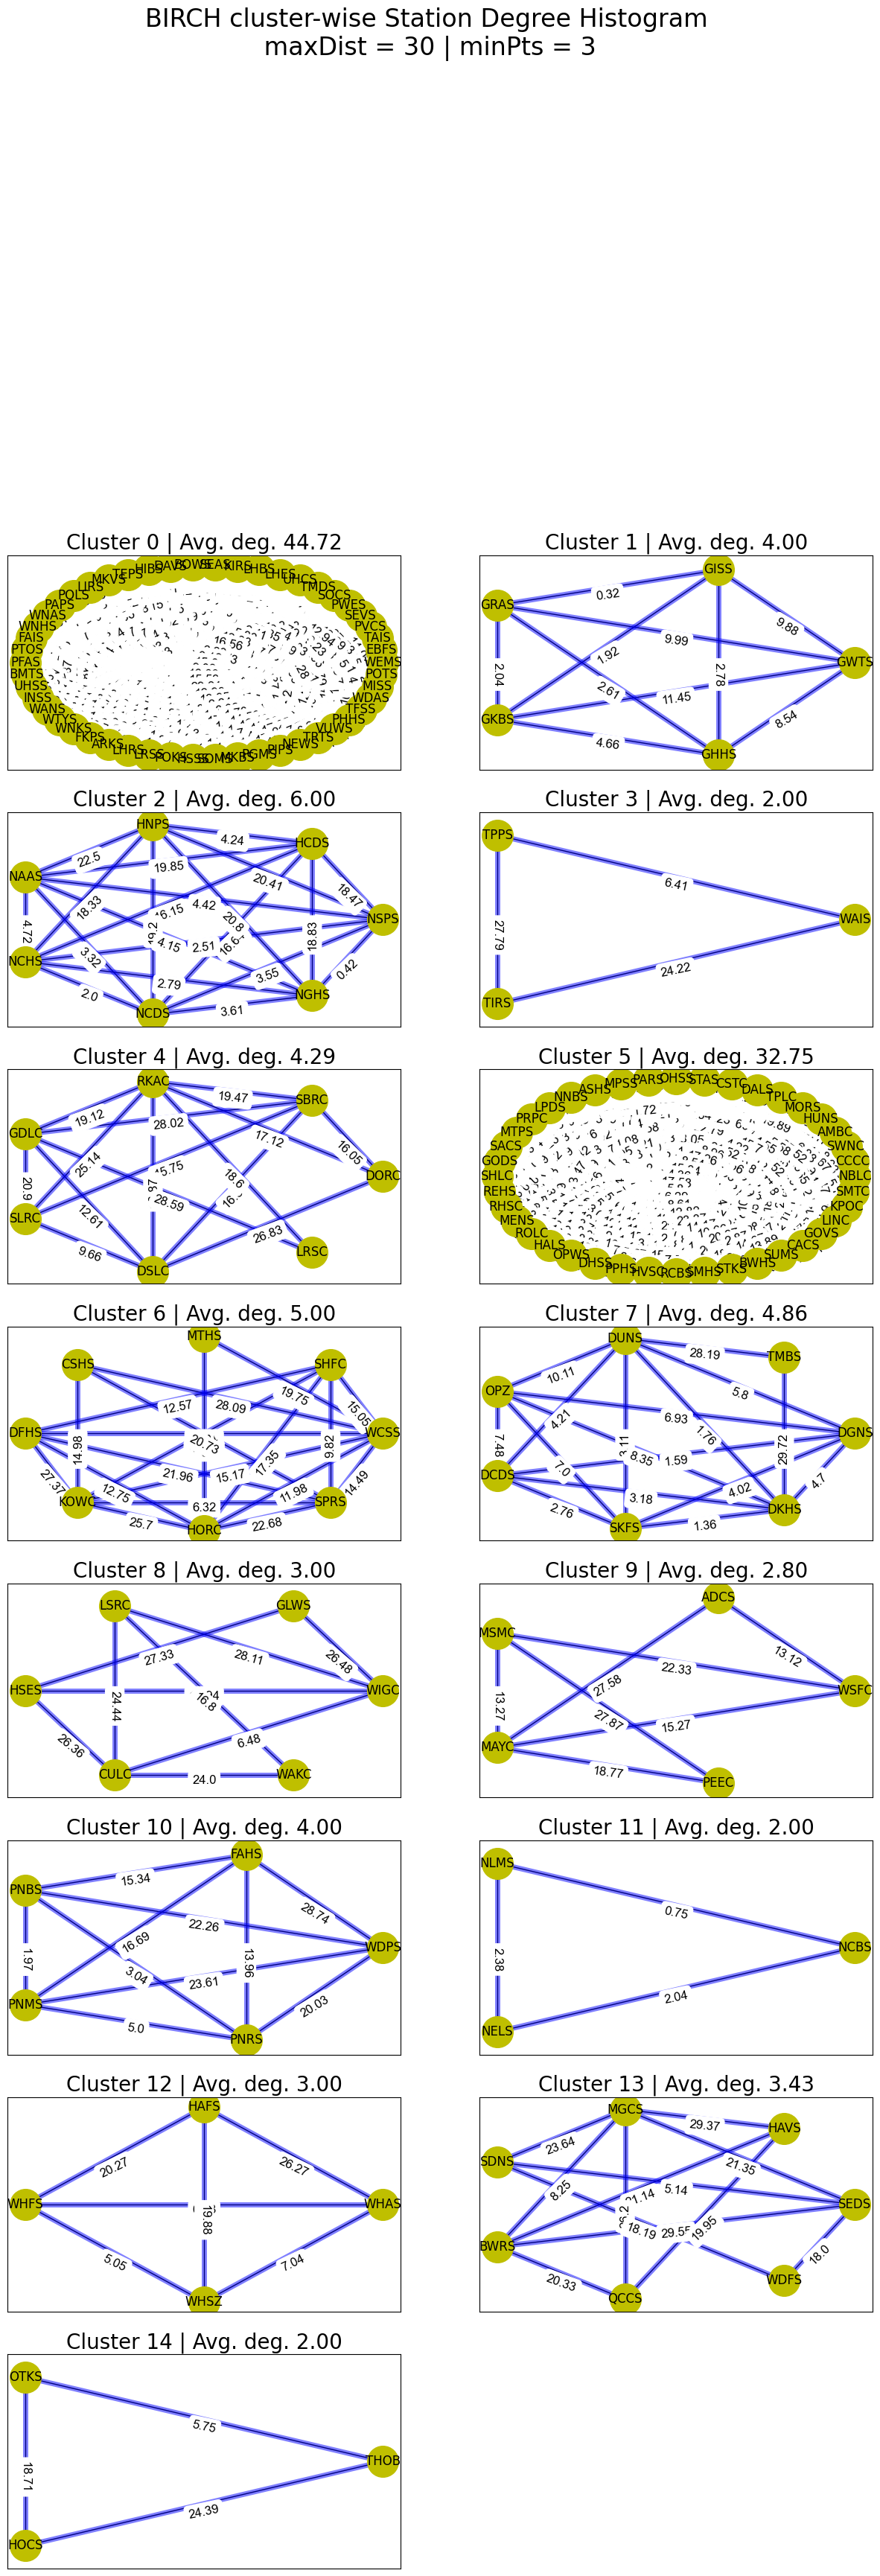

In [84]:
'''
    Plot all subgraphs
'''
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

if len(lst_G_simple) < 2:
    num_cols = len(lst_G_simple)%2
else:
    num_cols = 2
num_rows = math.ceil(len(lst_G_simple)/num_cols)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15,num_rows*4), dpi=100, sharex=False, sharey=True)

for clust_num, G in enumerate(lst_G_simple):
    edge_labels = nx.get_edge_attributes(G,'distance')
#    node_pos = nx.spring_layout(G, iterations=50)
    node_pos = nx.circular_layout(G)
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    _avg_degree = sum(degree_sequence)/len(degree_sequence)

    row_num = math.floor(clust_num/num_cols)
    col_num = clust_num%num_cols

    if num_rows ==1:
        if num_cols == 1:
            nx.draw_networkx(G, node_pos,node_size=900, node_color="y", node_shape='o', ax=ax)
            nx.draw_networkx_edges(G, node_pos, width=5.0, alpha=0.5,edge_color="b",ax=ax)
            nx.draw_networkx_edge_labels(G, node_pos,
                                         edge_labels=edge_labels, label_pos=0.5,
                                         font_size=12, font_family="Arial",
                                         horizontalalignment='center', verticalalignment='top',
                                         ax=ax)
            ax.set_title('Cluster %d | Avg. deg. %0.2f' % (clust_num,_avg_degree),size=20)
        else:
            nx.draw_networkx(G, node_pos,node_size=900, node_color="y", node_shape='o', ax=ax[col_num])
            nx.draw_networkx_edges(G, node_pos, width=5.0, alpha=0.5,edge_color="b",ax=ax[col_num])
            nx.draw_networkx_edge_labels(G, node_pos,
                                         edge_labels=edge_labels, label_pos=0.5,
                                         font_size=12, font_family="Arial",
                                         horizontalalignment='center', verticalalignment='top',
                                         ax=ax[col_num])
            ax[col_num].set_title('Cluster %d | Avg. deg. %0.2f' % (clust_num,_avg_degree),size=20)
    else:
        nx.draw_networkx(G, node_pos,node_size=900,
                         node_color="y", node_shape='o',
                         ax=ax[row_num,col_num])
        nx.draw_networkx_edges(G, node_pos, width=5.0,
                               alpha=0.5,edge_color="b",
                               ax=ax[row_num,col_num])
        nx.draw_networkx_edge_labels(G, node_pos,
                                     edge_labels=edge_labels, label_pos=0.5,
                                     font_size=12, font_family="Arial",
                                     horizontalalignment='center',
                                     verticalalignment='top',ax=ax[row_num,col_num])
        ax[row_num,col_num].set_title('Cluster %d | Avg. deg. %0.2f' % (clust_num,_avg_degree),size=20)

''' Set titles and ticks'''
_s_title = ("%s cluster-wise Station Degree Histogram\n maxDist = %d | minPts = %d"
            % (_s_cloud_clust_name, _l_max_distance, _n_min_cloud_clust_size)) 
plt.suptitle(_s_title,size=24, y=1.2)
#plt.suptitle(_s_cloud_clust_name + " cluster-wise Station Subgraphs",size=24, y=1.2)
fig.subplots_adjust(top=0.97)

''' remove empty plots '''
for i in range(len(lst_G_simple),num_cols*num_rows):
    fig.delaxes(ax[num_rows-1,i%2])

#dif _plot_valid_g:
#d    _s_plot_save_file = str("../images/outputs/all_valid_subg "+_s_cloud_clust_name+".png").replace(" ","_")
#delse:
#d    _s_plot_save_file = str("../images/outputs/all_subg "+_s_cloud_clust_name+".png").replace(" ","_")

_s_plot_save_file = str("../images/outputs/graph"+
                        "_clust-"+_s_cloud_clust_name+
                        "_forceReg-"+str(_force_regularity)+
                        "_minP-"+str(_n_min_cloud_clust_size)+
                        "_maxD-"+str(int(_l_max_distance))+
                        ".png").replace(" ","_")
plt.savefig(_s_plot_save_file, bbox_inches='tight')

plt.show()    

#### Make individual polts of network graphs
Change the ```cluster_num``` to any number between 0 and the maximum number of cluster -1

To verify the distances given in the graph:
* Retrieve the coordinates (and metadata) of a stations use the [Geonet services](https://service.geonet.org.nz/fdsnws/station/1/query?network=NZ&station=ARAZ&level=station&format=text) 

```https://service.geonet.org.nz/fdsnws/station/1/query?network=NZ&station=ARAZ&level=station&format=text```
* Change the ```&station=``` value to the desired station code (e.g. POIZ).

```output: NZ|POIZ|-38.630564|176.034230|598.000000|Poihipi|2001-02-24T00:00:00|```
* Apply the haversine distance to compute the distance between two coordinate sets using an [online calculator](https://www.movable-type.co.uk/scripts/latlong.html).

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


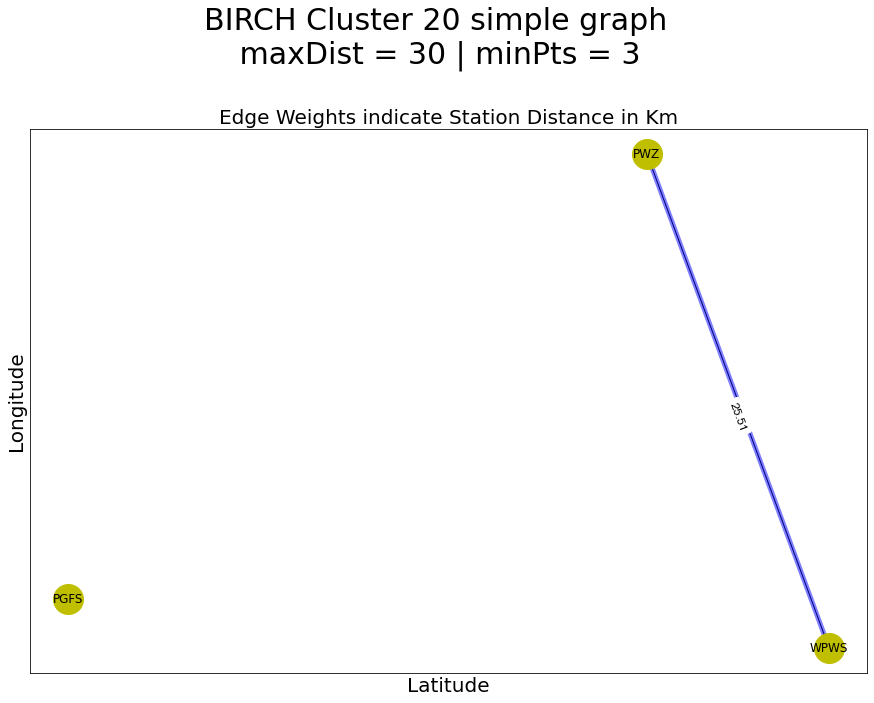

In [65]:
''' 
    Plot the Simple Graph corresponding to the cluster
    
    To plot the graph for any of the clusters change the clust_num (int) from 0 to n-1; where
    n is the number of clusters
    To toggle between viewing the minimum spanning tree and the graph uncomment and comment the
    code lines
    G = lst_clust_G_tree[clust_num]
    G = lst_clust_G_graph[clust_num]
    
    @parameters
    clust_number = integer value of any number between 0 and the maximum number of cluster -1
    G = nx.Graph() instance of the respecitve graph of the cluster from the list of cluster graphs
'''
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

''' TODO create a dataframe of graphs to locate by index number to remove issue related to mismatch
    between clust_number and actual cluster label'''
clust_num = 20
G = lst_G_simple[clust_num]
#fig, ax = plt.subplots(num_rows, num_cols, figsize=(15,num_rows*4), dpi=100, sharex=False, sharey=True)
#ax = plt.subplot()
plt.figure(figsize=(15,10))

node_pos=nx.get_node_attributes(G,'pos')
nx.draw_networkx(G, node_pos,node_size=900, node_color="y", node_shape='o')
nx.draw_networkx_edges(G, node_pos, width=5.0, alpha=0.5,edge_color="b")
edge_labels = nx.get_edge_attributes(G,'distance')
nx.draw_networkx_edge_labels(G, node_pos,
                             edge_labels=edge_labels, label_pos=0.5,
                             font_size=12, font_family="Arial",
                             horizontalalignment='center', verticalalignment='top')
_s_title = ('%s Cluster %d simple graph\n maxDist = %d | minPts = %d'
             % (_s_cloud_clust_name, clust_num, _l_max_distance, _n_min_cloud_clust_size)) 
plt.suptitle(_s_title, fontsize=30, y=1.05)
plt.title('Edge Weights indicate Station Distance in Km', fontsize=20)
plt.xlabel('Latitude', fontsize=20)
plt.ylabel('Longitude', fontsize=20)
xticks = [a[0] for a in list(node_pos.values())]
min_xtick = min(xticks)+1
max_xtick = max(xticks)-1
#plt.xticks(np.arange(min_xtick,max_xtick,step=2.0))
#ax.set_xticks(np.arange(min_xtick,max_xtick,step=2.0), minor=True)

#d_s_plot_save_file = ("../images/outputs/subg_%s_%d_%d_clust_%d.png"
#d                     % (_s_cloud_clust_name, _l_max_distance,
#d                        _n_min_cloud_clust_size, clust_num))
_s_plot_save_file = str("../images/outputs/subG"+
                            "_clust-"+_s_cloud_clust_name+
                            "_forceReg-"+str(_force_regularity)+
                            "_minP-"+str(_n_min_cloud_clust_size)+
                            "_maxD-"+str(int(_l_max_distance))+
                            ".png").replace(" ","_")
plt.savefig(str(_s_plot_save_file).replace(" ","_"), bbox_inches='tight')

plt.show()


### Voronoi diagram of the Station Clusters
A [Voronoi diagram is a collection of polygons](https://towardsdatascience.com/how-to-create-voronoi-regions-with-geospatial-data-in-python-adbb6c5f2134) with all the points on a plane that is closest to the single object - each polygon division correlates with a single object and contains all points which are closest to this single object.

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


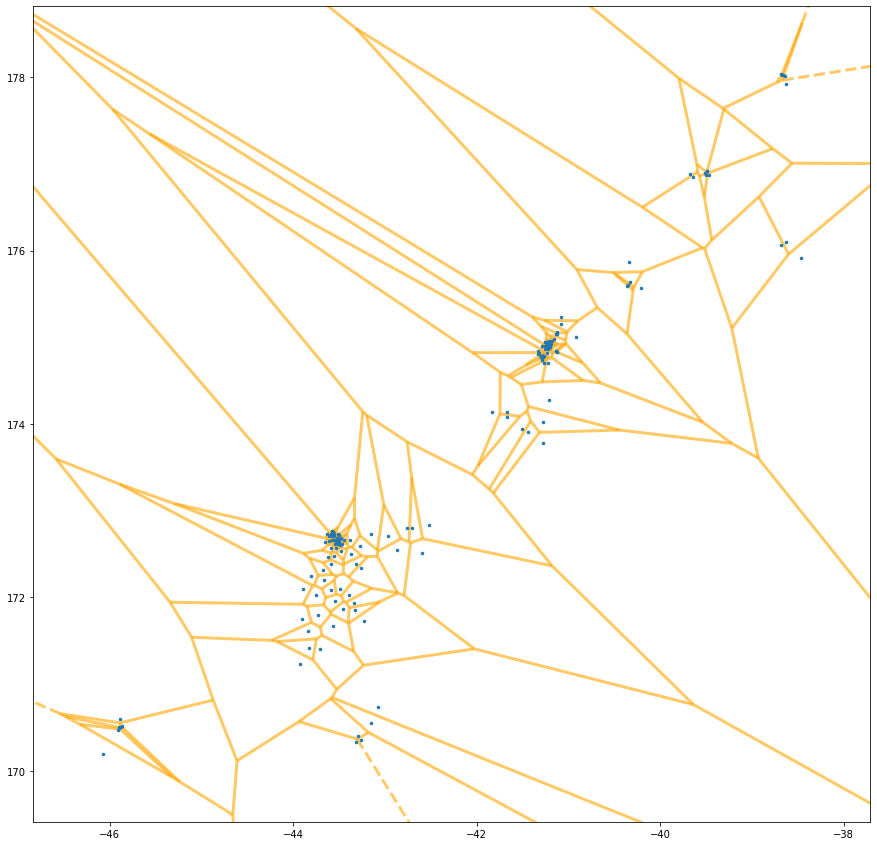

In [48]:
'''
    PLOT Voroni diagram of the stations
    TODO put inside geographic boundary
'''
from scipy.spatial import Voronoi, voronoi_plot_2d
#arr_clust_coords = np.array([[row[0],row[6]] for row in l_st_flt_clust])
#print([labels[:],scaled_features[:, 0], scaled_features[:, 1]])
#arr_coord = np.array(list([row[2][0],row[2][1]] for row in station_coordinates))
vor = Voronoi(g_node_pos)
#fig = voronoi_plot_2d(vor)
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', 
                      line_width=3, line_alpha=0.6, point_size=5)
fig.set_size_inches(15,15)
#plt.axis("equal")
#plt.xlim

## Deprecated Code

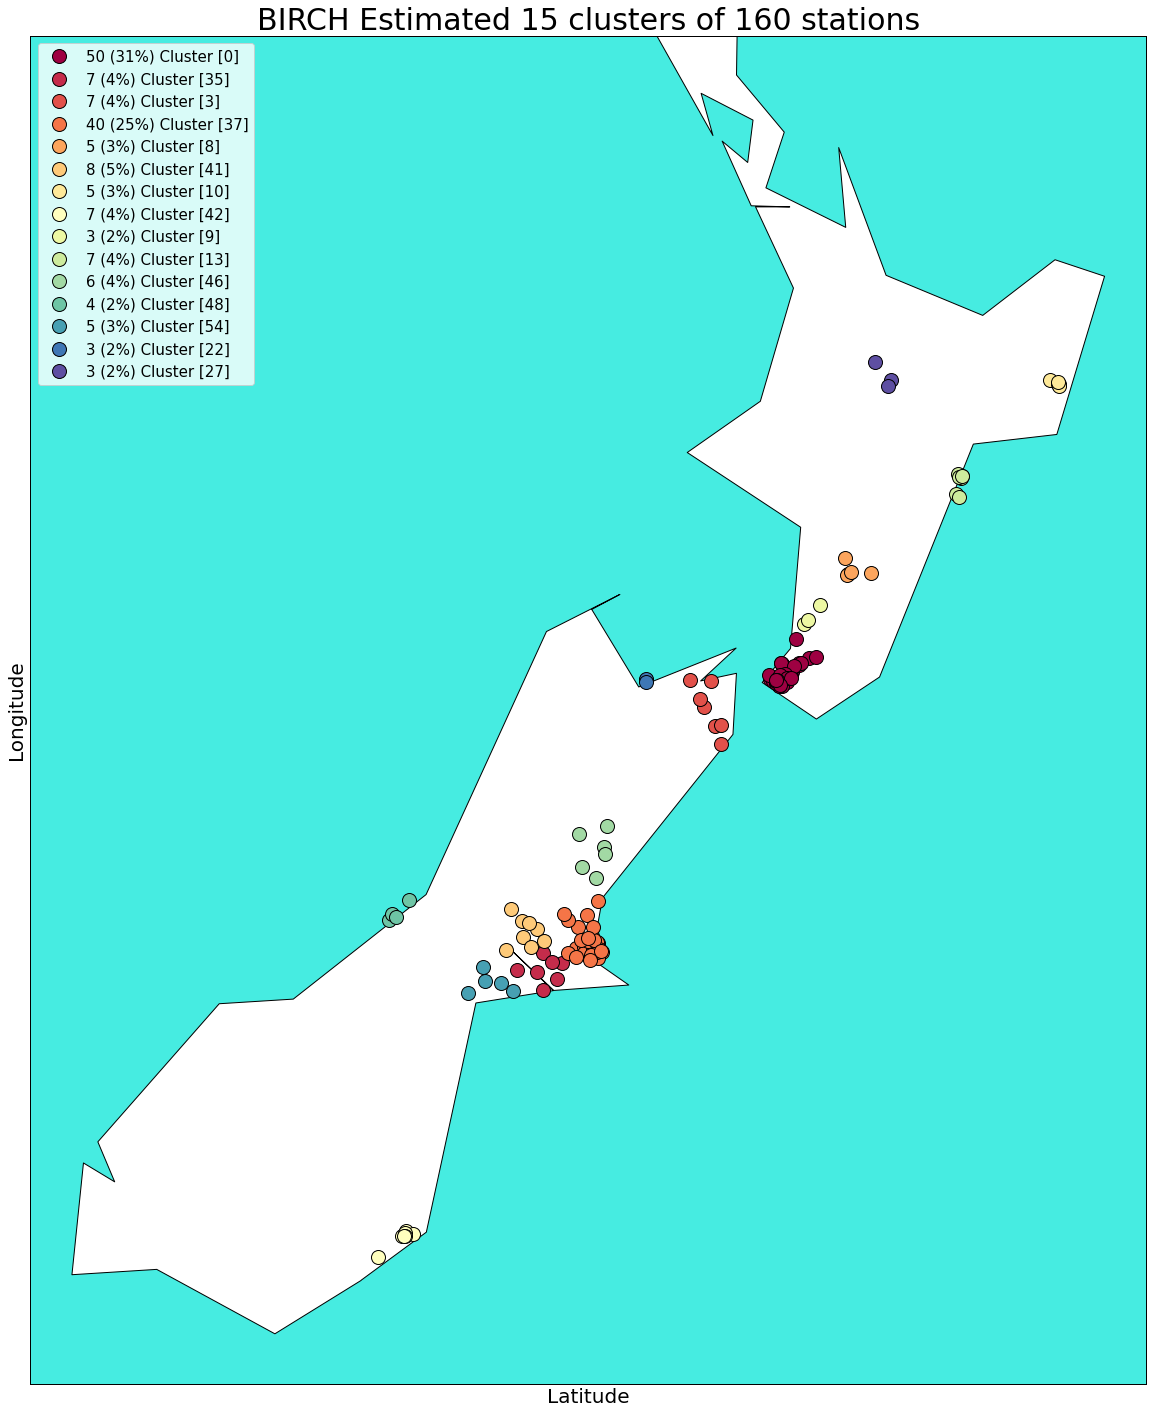

In [90]:
''' DEPRECATED because new force_regularity and plot above replaces this '''
''' Plot Clusters on a Base Map '''
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import networkx as nx

''' Use list slice to plot all or a specific set of subgraphs 
    e.g., if you have 18 subgraphs [0,17]; to plot
            all: s = slice (0,18); 
    2nd to 6th: s = slice(1,6) 
'''
s = slice(0,66)

''' construct an array of [pos]istions and [label]s for the subgraphs'''
G=nx.empty_graph()
for sub_graph in lst_G_simple[s]:
    G=nx.compose(G,sub_graph)

g_node_pos = np.array(list([lat,lon] for lat,lon in nx.get_node_attributes(G,'pos').values()))
g_labels = np.array(list([label] for label in nx.get_node_attributes(G,'label').values()))
g_nodes = np.append(g_node_pos, g_labels, axis=1)
st_lat = g_nodes[:,0]
st_lon = g_nodes[:,1]

# create map using BASEMAP
lat_min = min(st_lat) - 1
lat_max = max(st_lat) + 3
lon_min = min(st_lon) - 4
lon_max = max(st_lon) + 1

plt.figure(figsize=(20, 35))
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lon_max-lon_min)/2,
            projection='merc',
            resolution = 'c',
            area_thresh=10000.,
           )

m.drawcoastlines()
m.drawcountries()
#m.drawstates()
m.drawmapboundary(fill_color='#46ece1')
m.fillcontinents(color = 'white',lake_color='#46bcec')

unique_labels = set(nx.get_node_attributes(G,'label').values())
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    xy = np.array([x for i,x in enumerate(g_nodes) if np.any(g_nodes[i][2] == k)])
    s_legend = str(len(xy))+' ('+str(round(100*len(xy)/len(g_nodes)))+'%) Cluster ['+str(int(k))+']'
    x,y = m(xy[:, 1], xy[:, 0])
    m.plot(x, y, 'o', markerfacecolor=tuple(col),
           markeredgecolor='k', markersize=14, label=s_legend)

plt.title('%s Estimated %d clusters of %d stations' 
          % (_s_cloud_clust_name.replace("_"," ").upper(), 
             len(lst_G_simple), g_nodes.shape[0]), fontsize=30)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc='upper left', fontsize=15)
plt.xlabel('Latitude', fontsize=20)
plt.ylabel('Longitude', fontsize=20)
plt.show()

In [56]:
''' DEPRECATED because r-regularity function is returning the subgraph list '''
import sys; sys.path.insert(1, '../lib')
import graph_clustering as gc
import networkx as nx

if debug:
    import importlib
    gc = importlib.reload(gc)

''' plot only subgraphs that comply with r-regularity where r >= minPts
    Given that the regularity is based on the average degree, change the scaling value 0.95
    to one that is desired and in the interval (0,1] to set a regularity threshold @_f_reg_thresh
'''
lst_G_simple = []
''' Only plot valid clusters '''
#no_noise_df = __st_clust_df[__st_clust_df['label']!= -1]
print('%d clusters with noise were generated by %s.' % 
      (len(__st_clust_df['label'].unique()),
       _s_cloud_clust_name))
no_noise_df = __st_clust_df[__st_clust_df['label']!= -1]
print('%d clusters after removing the noise clusters; i.e. label = -1' % 
      len(no_noise_df['label'].unique()))

dict_feature_params = {"distance_km": _l_max_distance,
                       "minimum_samples": _n_min_cloud_clust_size}
cls_g_clust = gc.community_detection(**dict_feature_params)
G_simple = cls_g_clust.get_simple_graph(no_noise_df)
G_simple.remove_nodes_from(list(nx.isolates(G_simple)))
if not nx.is_empty(G_simple):
    lst_G_simple = cls_g_clust.get_list_subgraphs(G_simple)
print('%d simple subgraphs created after removing clusters with isolated nodes' % len(lst_G_simple))

print('%d simple subgraphs remaining after validating with parameters:'
      % (len(lst_G_simple)))

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


66 clusters with noise were generated by BIRCH.
66 clusters after removing the noise clusters; i.e. label = -1
39 simple subgraphs created after removing clusters with isolated nodes
39 simple subgraphs remaining after validating with parameters:


In [25]:
''' DEPRECATE after changing to receive sub_graph_list'''
''' Create a list of subgraphs for each cluster to support
    plotting degree histograms and graphs '''

import sys; sys.path.insert(1, '../lib')
import graph_clustering as gc
import networkx as nx

if debug:
    import importlib
    gc = importlib.reload(gc)

''' plot only subgraphs that comply with r-regularity where r >= minPts
    Given that the regularity is based on the average degree, change the scaling value 0.95
    to one that is desired and in the interval (0,1] to set a regularity threshold @_f_reg_thresh
'''
_l_reg_methods = ['Absolute','Average']
#_force_minPts = True               # force to remove subgraphs with < minPts
_force_regularity = 'Average'     # force Absolute, Average, or None regularity
_f_reg_thresh = 0.99*_n_min_cloud_clust_size     # value greater than 0 and less than 1.0   

lst_G_simple = []
''' Only plot valid clusters '''
#no_noise_df = __st_clust_df[__st_clust_df['label']!= -1]
print('%d clusters with noise were generated by %s.' % 
      (len(__st_clust_df['label'].unique()),
       _s_cloud_clust_name))
no_noise_df = __st_clust_df[__st_clust_df['label']!= -1]
print('%d clusters after removing the noise clusters; i.e. label = -1' % 
      len(no_noise_df['label'].unique()))
#dif _force_minPts:
if _force_regularity in _l_reg_methods:
    for k in no_noise_df['label'].unique():
        temp_df = pd.DataFrame([])
        temp_df = no_noise_df.loc[lambda no_noise_df: no_noise_df['label'] == k]
        if temp_df.shape[0] < int(_n_min_cloud_clust_size+1):
            no_noise_df = no_noise_df[no_noise_df['label'] != k]
print('%d clusters remaining after removing clusters with minPts < %d+1 for %d-regularity minimum requirement' % 
      (len(no_noise_df['label'].unique()),_n_min_cloud_clust_size,_n_min_cloud_clust_size))

dict_feature_params = {"distance_km": _l_max_distance,
                       "minimum_samples": _n_min_cloud_clust_size}
cls_g_clust = gc.community_detection(**dict_feature_params)
G_simple = cls_g_clust.get_simple_graph(no_noise_df)
G_simple.remove_nodes_from(list(nx.isolates(G_simple)))
if not nx.is_empty(G_simple):
    lst_G_simple = cls_g_clust.get_list_subgraphs(G_simple)
print('%d simple subgraphs created after removing clusters with isolated nodes' % len(lst_G_simple))

''' remove any graphs with zero average degree '''
incomplete = True     #flag to start stop while loop
while incomplete:
    incomplete = False
    ''' first remove all subgraphs with zero degree nodes; i.e. singletons '''
    for G_idx, G in enumerate(lst_G_simple):
        if len(G.edges()) == 0:
            lst_G_simple.pop(G_idx)
            print('...removed subgraph %d with null degree' % G_idx)
            incomplete = True

    for G_idx, G in enumerate(lst_G_simple):
        ''' _min_regularity=True remove subgraphs with low minimum degree '''
        degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
        ''' TODO fix this beacuse average does not reflect the truth if several nodes have a large degree '''
        _avg_degree = sum(degree_sequence)/len(degree_sequence)
        if _force_regularity == 'Average' and _avg_degree <= _f_reg_thresh:
            try:
                lst_G_simple.pop(G_idx)
                print('...removed subgraph %d with average degree %0.02f <= %0.02f tolerated degree'
                      % (G_idx, _avg_degree,_f_reg_thresh))
                incomplete = True
            except Exception as err:
                pass

        elif _force_regularity == 'Absolute':
            H = nx.Graph(G)
            remove = [node for node,degree in dict(H.degree()).items() if degree < _f_reg_thresh]
            if len(remove) > 0:
                print('...removing nodes %s with degree <= %0.02f'
                      % (remove, _f_reg_thresh))
                H.remove_nodes_from(remove)
                if H.number_of_nodes() > 0:
                    lst_G_simple.pop(G_idx)
                    lst_G_simple.append(H)
                    print('...replaced subgraph %d with reduced nodes=%d'
                          % (G_idx, H.number_of_nodes()))
                else:
                    print('...removing subgraph %d with %d nodes after node removal'
                          % (G_idx, H.number_of_nodes()))
                    lst_G_simple.pop(G_idx)
                incomplete = True

print('%d simple subgraphs remaining after validating with parameters:'
      % (len(lst_G_simple)))
print('   degree tolerance of %0.02f and forced regularity function set to %s.'
      % (_f_reg_thresh, _force_regularity))

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


66 clusters with noise were generated by BIRCH.
66 clusters after removing the noise clusters; i.e. label = -1
19 clusters remaining after removing clusters with minPts < 3+1 for 3-regularity minimum requirement
19 simple subgraphs created after removing clusters with isolated nodes
...removed subgraph 2 with null degree
...removed subgraph 1 with average degree 1.33 <= 2.97 tolerated degree
...removed subgraph 3 with average degree 1.67 <= 2.97 tolerated degree
...removed subgraph 5 with average degree 1.60 <= 2.97 tolerated degree
...removed subgraph 8 with average degree 1.50 <= 2.97 tolerated degree
...removed subgraph 10 with average degree 1.33 <= 2.97 tolerated degree
...removed subgraph 11 with average degree 2.80 <= 2.97 tolerated degree
...removed subgraph 5 with average degree 2.00 <= 2.97 tolerated degree
...removed subgraph 10 with average degree 2.80 <= 2.97 tolerated degree
10 simple subgraphs remaining after validating with parameters:
   degree tolerance of 2.97 and fo

# Incomplete Code

In [9]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# generate the linkage matrix
#X = locations_in_RI[['Latitude', 'Longitude']].values
Z = linkage(station_coordinates,
            method='complete',  # dissimilarity metric: max distance across all pairs of 
                                # records between two clusters
            metric='euclidean'
    )                           # you can peek into the Z matrix to see how clusters are 
                                # merged at each iteration of the algorithm

# calculate full dendrogram and visualize it
plt.figure(figsize=(30, 10))
dendrogram(Z)
plt.show()

# retrive clusters with `max_d`
from scipy.cluster.hierarchy import fcluster
max_d = _l_max_distance/6371.088       # I assume that your `Latitude` and `Longitude` columns are both in 
                 # units of kilometers
clusters = fcluster(Z, max_d, criterion='distance')
print(clusters)

NameError: name 'station_coordinates' is not defined

In [13]:
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize=(15,10))
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

NameError: name 'clusterer' is not defined

<Figure size 1080x720 with 0 Axes>

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
plt.scatter(*X.T, s=50, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*X[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)

NameError: name 'clusterer' is not defined

<Figure size 1080x720 with 0 Axes>

In [14]:
pal = sns.color_palette('deep', 8)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_,
                                                            clusterer.probabilities_)]
plt.scatter(station_coordinates.T[0], station_coordinates.T[1], c=colors, **plot_kwds);

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'clusterer' is not defined

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(15,10))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)